In [1]:
import os
import json
from ultralytics import YOLO
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from paddleocr import PaddleOCR

from datasets import load_dataset, concatenate_datasets
from transformers import T5Tokenizer
from torch.utils.data import DataLoader
from transformers import T5ForConditionalGeneration
from transformers import Trainer, TrainingArguments
import torch

from sklearn.mixture import GaussianMixture
from scipy.optimize import linear_sum_assignment
from skimage.color import deltaE_ciede2000, rgb2lab
from sklearn.cluster import KMeans

In [2]:
# Calling YOLO Model
# Path to your trained model weights and test image
model_path = "run2/detect/final_model_continued/weights/best.pt"
# Load the trained model
model = YOLO(model_path)

In [3]:
save_path = "fine_tuned_t5_updated/"

t5_model = T5ForConditionalGeneration.from_pretrained(save_path)
tokenizer = T5Tokenizer.from_pretrained(save_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
t5_model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

# Common Functions for Line & Bar Charts

# Image Processing

### Predict the image using YOLO

In [4]:
def predict_and_display(model, image, save_path, imgsz=800, conf=0.5):
    """
    Uses a trained model to predict on an image, displays the prediction, and saves the resulting output image.
    
    This function is designed to work with models that have a 'predict' method returning results that 
    can be visualized and saved. It leverages the following components:
      - model.predict(): To perform predictions on the input image.
      - Image.fromarray(): From the PIL library to convert an array (image) into an Image object.
      - display(): To render the image in an interactive environment (such as Jupyter Notebook).
      - The save() method on the result to persist the image output.
    
    Args:
        model: A trained prediction model that implements a 'predict' method.
        image: The input image on which predictions are to be made. The image must be in a format accepted 
               by the model's predict method.
        save_path (str): File path (including name and extension) where the predicted output image will be saved.
        imgsz (int, optional): The size to which the image should be resized (or interpreted) for prediction. 
                               Defaults to 800.
        conf (float, optional): Confidence threshold for prediction; only predictions with confidence above 
                                this value will be considered. Defaults to 0.5.
    
    Returns:
        The prediction results from the model. The output is typically a list or similar collection where 
        each element represents a prediction result, which includes methods for visualization (plot) and saving (save).
    """
    # Make predictions on the image using the model's predict function
    results = model.predict(source=image, imgsz=imgsz, conf=conf)
    
    # Display the prediction result using the first result's plot() method, converting it from an array to an Image.
    display(Image.fromarray(results[0].plot()))
    
    # Save the predicted image to the specified save path using the result's save() method.
    results[0].save(save_path)
    
    # Return the prediction results
    return results

In [5]:
def yolo_training_results_to_json(yolo_results):
    """
    Converts YOLO training results into a JSON-compatible list of annotations.
    
    This function processes a list of YOLO detection results, extracting bounding box coordinates,
    confidence scores, class indices, and corresponding labels. It iterates over each result (which 
    is expected to have a 'boxes' attribute containing detected boxes) and then processes each detected box.
    For each detection, it extracts the following details:
      - Coordinates in xyxy format (top-left and bottom-right)
      - Confidence score
      - Class index (converted to an integer)
      - Label (retrieved from the model's names dictionary using the class index)
    
    The function relies on methods and attributes from the YOLO model's detection results:
      - Each `result` should have an attribute `boxes` which is iterable.
      - Each `box` is expected to have attributes `xyxy`, `conf`, and `cls`, which are tensors.
      - The `.cpu().numpy().tolist()` chain is used to convert these tensors into standard Python lists.
      - The `result.names` dictionary maps class indices to human-readable labels.
    
    Args:
        yolo_results (list): A list of YOLO detection results. Each element should be an object
                             containing a 'boxes' attribute and a 'names' dictionary.
    
    Returns:
        list: A list of dictionaries where each dictionary represents an annotation with keys:
              "coordinates" (list of float): [x1, y1, x2, y2] of the bounding box.
              "confidence" (float): Confidence score for the detection.
              "class" (int): Class index of the detected object.
              "label" (str): Human-readable label corresponding to the class index.
    """
    annotations = []
    # Loop over each result object in the provided YOLO results
    for result in yolo_results:
        # Each result contains detected boxes in the 'boxes' attribute
        for box in result.boxes:
            # Extract coordinates in xyxy format (top-left and bottom-right)
            coords = box.xyxy.cpu().numpy().tolist()[0]  # Example: [x1, y1, x2, y2]
            # Extract the confidence score for the detection
            confidence = box.conf.cpu().numpy().tolist()[0]
            # Extract the class index and ensure it's an integer
            cls = int(box.cls.cpu().numpy()[0])
            # Retrieve the corresponding label from the model's names dictionary
            label = result.names[cls]

            # Create a dictionary for this detection
            annotation = {
                "coordinates": coords,
                "confidence": confidence,
                "class": cls,
                "label": label
            }
            # Append the annotation to the list of annotations
            annotations.append(annotation)

    return annotations

In [6]:
def process_chart_image(image_path, detections):
    """
    Processes a chart image by detecting and cropping various chart components, enhancing their quality,
    and performing OCR (Optical Character Recognition) to extract text from each component.
    
    This function performs the following steps:
      1. Loads the image from the given path using OpenCV.
      2. Defines basic pre-processing functions:
            - sharpen_image(): Applies a sharpening kernel to enhance image details.
            - denoise_image(): Applies fast non-local means denoising to reduce noise in the image.
      3. Defines an advanced pre-processing function (advanced_preprocessing) which:
            - Applies super-resolution using OpenCV's DNN Super Resolution module (requires 'EDSR_x4.pb').
            - Applies morphological operations (opening and closing) on the grayscale image to remove noise.
            - Enhances contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization).
      4. Applies sharpening and denoising to the full image before cropping.
      5. Iterates over provided detections (which are assumed to be dictionaries containing 'label'
         and 'coordinates') to categorize and store bounding box coordinates for various chart elements,
         including data points, axis ticks, axis titles, title, legend, and plotting area (for Bar, Line, or Pie charts).
      6. Sorts detections within each category by x or y coordinate to standardize the order.
      7. Crops each detected component from the pre-processed image, re-applies sharpening and denoising
         repeatedly after cropping, and then applies the advanced pre-processing.
      8. Initializes PaddleOCR (with angle classification enabled and set to English) to extract text from each cropped image.
      9. Performs OCR on each processed cropped image and stores the extracted text in a dictionary.
      10. Optionally displays each processed cropped image using Matplotlib for visual verification.
    
    Functions and libraries used:
      - cv2.imread, cv2.filter2D, cv2.fastNlMeansDenoisingColored, cv2.dnn_superres.DnnSuperResImpl_create,
        cv2.morphologyEx, cv2.createCLAHE: For image processing and enhancement.
      - np.ones, np.array, np.where, cv2.cvtColor: For array and image manipulations.
      - PaddleOCR: For optical character recognition.
      - plt.imshow, plt.title, plt.axis, plt.show: For displaying images using Matplotlib.
    
    Args:
        image_path (str): File path to the chart image that needs to be processed.
        detections (list): A list of dictionaries where each dictionary contains:
                           - "label": A string indicating the type of chart component (e.g., "Data Points", "X Axis Ticks").
                           - "coordinates": A list or tuple with four numbers [x1, y1, x2, y2] defining the bounding box of the component.
    
    Returns:
        dict: A dictionary (ocr_results) where each key is an identifier for the cropped image component
              (e.g., "data_point_label_1") and the value is the OCR extracted text from that component.
    """
    
    # Load the image from disk using OpenCV
    image = cv2.imread(image_path)

    # Define a basic pre-processing function to sharpen an image
    def sharpen_image(img):
        """Applies a sharpening filter to the given image."""
        sharpening_kernel = np.array([[0, -1, 0],
                                      [-1, 5, -1],
                                      [0, -1, 0]])
        return cv2.filter2D(img, -1, sharpening_kernel)

    # Define a basic pre-processing function to denoise an image
    def denoise_image(img):
        """Applies fast non-local means denoising to reduce noise in the image."""
        return cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

    # Advanced pre-processing combining super-resolution, morphological operations, and CLAHE
    def advanced_preprocessing(img):
        """
        Enhances the quality of the cropped image by applying:
          1. Super-Resolution: Upscales the image using the EDSR model (requires 'EDSR_x4.pb').
          2. Morphological Operations: Applies opening and closing operations on a grayscale version of the image.
          3. Contrast Enhancement: Uses CLAHE to improve contrast.
        
        Args:
            img (np.array): The image to be processed.
        
        Returns:
            np.array: The enhanced image after advanced pre-processing.
        """
        # 1. Super-Resolution
        try:
            sr = cv2.dnn_superres.DnnSuperResImpl_create()
            # The model file 'EDSR_x4.pb' must be available in the working directory.
            sr.readModel("EDSR_x4.pb")
            sr.setModel("edsr", 4)  # Set model to EDSR with a scaling factor of 4.
            img = sr.upsample(img)
        except Exception as e:
            print("Super-resolution skipped:", e)
        
        # 2. Morphological Operations: Convert image to grayscale and apply opening and closing to remove noise.
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kernel = np.ones((3, 3), np.uint8)
        morph = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
        morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel)
        
        # 3. Contrast Enhancement using CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(morph)
        return enhanced

    # Apply basic pre-processing (sharpening and denoising) to the full image before cropping components.
    image = sharpen_image(image)
    image = denoise_image(image)

    # Initialize lists to store bounding boxes for different chart components.
    data_points, x_axis_ticks, y_axis_ticks = [], [], []
    x_axis_title, y_axis_title, title, legend = [], [], [], []
    plotting_area, chart_type = [], []

    # Iterate over each detection, filtering based on the label and storing coordinates accordingly.
    for detection in detections:
        label = detection['label']
        coords = detection['coordinates']
        x1, y1, x2, y2 = map(int, coords)

        if label == "Data Points":
            data_points.append((x1, y1, x2, y2))
        elif label == "X Axis Ticks":
            x_axis_ticks.append((x1, y1, x2, y2))
        elif label == "Y Axis Ticks":
            y_axis_ticks.append((x1, y1, x2, y2))
        elif label == "X Axis Title":
            x_axis_title.append((x1, y1, x2, y2))
        elif label == "Y Axis Title":
            y_axis_title.append((x1, y1, x2, y2))
        elif label == "Title":
            title.append((x1, y1, x2, y2))
        elif label == "Legend":
            legend.append((x1, y1, x2, y2))
        elif label in ["Bar Chart", "Line Chart", "Pie Chart"]:
            plotting_area.append((x1, y1, x2, y2))
            chart_type.append(label)

    # Sort detection boxes within each category for consistency.
    data_points.sort(key=lambda box: box[0])  # Sort by x-coordinate.
    x_axis_ticks.sort(key=lambda box: box[0])
    y_axis_ticks.sort(key=lambda box: box[1], reverse=True)  # Sort by y-coordinate in descending order.

    # Dictionary to store cropped and processed images for each detected component.
    cropped_images = {}

    # Inner function to crop elements from the image, apply additional pre-processing, and store them.
    def crop_and_store(elements, key_prefix):
        """
        Crops elements from the pre-processed image and applies additional pre-processing steps.
        
        For each element in the provided list, this function crops the image using the element's bounding box,
        applies repeated sharpening and denoising, then applies advanced pre-processing (super-resolution, 
        morphological operations, CLAHE), and finally stores the result in the 'cropped_images' dictionary.
        
        Args:
            elements (list): List of tuples, each containing coordinates (x1, y1, x2, y2) for cropping.
            key_prefix (str): Prefix for naming keys in the 'cropped_images' dictionary.
        """
        for i, (x1, y1, x2, y2) in enumerate(elements, start=1):
            crop = image[y1:y2, x1:x2]

            # Apply repeated sharpening and denoising after cropping to further enhance image quality.
            crop = sharpen_image(crop)
            crop = sharpen_image(crop)
            crop = denoise_image(crop)
            
            # Apply advanced pre-processing: super-resolution, morphological operations, and CLAHE.
            processed_crop = advanced_preprocessing(crop)
            
            # Store the final processed image in the dictionary with a unique key.
            cropped_images[f"{key_prefix}_{i}"] = processed_crop

    # Crop and process each group of chart components.
    crop_and_store(data_points, "data_point_label")
    crop_and_store(x_axis_ticks, "x_axis_ticks")
    crop_and_store(y_axis_ticks, "y_axis_ticks")
    crop_and_store(x_axis_title, "x_axis_title")
    crop_and_store(y_axis_title, "y_axis_title")
    crop_and_store(title, "title")
    crop_and_store(legend, "legend")

    # Initialize PaddleOCR for text extraction; this OCR instance is set to detect text in English
    # and includes angle classification to handle rotated text.
    ocr = PaddleOCR(use_angle_cls=True, lang="en")

    # Dictionary to store OCR results for each processed cropped image.
    ocr_results = {}

    # Process each cropped and pre-processed image with OCR.
    for key, crop in cropped_images.items():
        result = ocr.ocr(crop, cls=True)
        extracted_text = []
        if result:
            for line in result:
                if line:
                    for word_info in line:
                        if word_info and len(word_info) > 1 and word_info[1] and len(word_info[1]) > 0:
                            extracted_text.append(word_info[1][0])
        # Concatenate extracted words into a single string for each cropped image.
        ocr_results[key] = " ".join(extracted_text)

    # Print OCR results for each cropped image for debugging and verification.
    for key, text in ocr_results.items():
        print(f"{key}: {text}")

    # Optionally, display the final processed cropped images using Matplotlib.
    for key, crop in cropped_images.items():
        plt.figure()
        plt.imshow(crop, cmap="gray")
        plt.title(key)
        plt.axis("off")
        plt.show()

    # Return the dictionary of OCR results.
    return ocr_results

# Functions for Charts Without Data Point Labels

### Image Preprocessing

In [7]:
def get_plot_coordinates(annotations, valid_labels=("Line Chart", "Bar Chart", "Pie Chart")):
    """
    Extracts plotting coordinates and corresponding labels from a list of annotation dictionaries.

    This function iterates through the provided annotations (each being a dictionary that must contain
    a 'label' and 'coordinates'). It checks if the annotation's label matches one of the specified chart types
    (by default: "Line Chart", "Bar Chart", or "Pie Chart"). For each matching annotation, it collects the
    coordinates and the label into separate lists.

    Args:
        annotations (list): A list of dictionaries, where each dictionary represents an annotation with at least:
                            - "label": A string indicating the type of chart element (e.g., "Line Chart").
                            - "coordinates": The coordinates (typically in [x1, y1, x2, y2] format) for that element.
        valid_labels (tuple, optional): A tuple of strings representing the accepted chart labels. 
                                        Defaults to ("Line Chart", "Bar Chart", "Pie Chart").

    Returns:
        tuple: Two separate lists:
            - plot_coordinates (list): A list of coordinate sets for annotations with valid labels.
            - labels_list (list): A list of labels corresponding to the extracted coordinates.
    """
    plot_coordinates = []
    labels_list = []
    
    for item in annotations:
        if item['label'] in valid_labels:
            plot_coordinates.append(item["coordinates"])
            labels_list.append(item["label"])
    
    return plot_coordinates, labels_list

In [8]:
def preprocess_plotting_area(image_path, plotting_area_coords):
    """
    Preprocesses the plotting area of a chart image for further analysis.

    This function performs the following steps:
      1. Loads the image from the specified file path using OpenCV.
      2. Extracts the plotting area from the image based on provided coordinates.
      3. Converts the cropped plotting area to grayscale.
      4. Applies Gaussian blur to the grayscale image to reduce noise.

    It utilizes the following OpenCV functions:
      - cv2.imread: To load the image.
      - cv2.cvtColor: To convert the image from BGR to grayscale.
      - cv2.GaussianBlur: To apply a Gaussian blur for noise reduction.

    Args:
        image_path (str): The file path to the chart image.
        plotting_area_coords (tuple or list): A set of four coordinates (x_min, y_min, x_max, y_max)
                                              defining the region of the plotting area to crop.

    Returns:
        np.array: A preprocessed (blurred grayscale) image of the plotting area.
    """
    # Load the image from the given path using OpenCV.
    image = cv2.imread(image_path)

    # Extract plotting area coordinates: x_min, y_min, x_max, y_max.
    x_min, y_min, x_max, y_max = plotting_area_coords

    # Crop the plotting area from the full image using the specified coordinates.
    cropped = image[int(y_min):int(y_max), int(x_min):int(x_max)]

    # Convert the cropped image to grayscale for further processing.
    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the grayscale image to reduce noise.
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Return the preprocessed image.
    return blurred

In [9]:
def crop_by_percentage(image):
    """
    Crops an image by removing a specified percentage from the top margin.

    This function calculates the top margin as 1% of the image's height and crops the image 
    from that margin down to the bottom. It is useful for removing unwanted small areas (e.g., headers)
    from the top of an image.

    Args:
        image (np.array): The input image as a NumPy array.

    Returns:
        np.array: The cropped image with the top 1% removed.
    """
    # Get original image dimensions (height and width)
    height, width = image.shape[:2]

    # Calculate the top margin as 1% of the image height
    top_margin = int(height * 0.01)

    # Crop the image from the calculated top margin to the bottom, keeping all columns
    cropped_image = image[top_margin:height, :]

    return cropped_image

In [10]:
def find_dynamic_threshold(image):
    """
    Computes a dynamic threshold value for a grayscale image by analyzing its histogram.
    
    This function performs the following steps:
      1. Computes the histogram of the input grayscale image using OpenCV's cv2.calcHist.
      2. Identifies the highest peak (i.e., the intensity value with the maximum frequency).
      3. Sorts all intensity values in descending order based on their frequency.
      4. Searches for a second peak that is sufficiently separated from the highest peak (between 50 and 100 intensity units away).
      5. If a valid second peak is not found, it defaults the second peak to a value of 155.
      6. Computes a dynamic threshold as a weighted average of the highest peak (30%) and the second peak (70%).
    
    The function leverages the following methods and libraries:
      - cv2.calcHist: To compute the histogram of the grayscale image.
      - numpy functions (np.argmax, np.argsort): To analyze the histogram data.
    
    Args:
        image (np.array): A grayscale image represented as a NumPy array.
    
    Returns:
        tuple: A tuple containing:
            - highest_peak (int): The intensity value with the maximum frequency.
            - second_peak (int): The second highest peak found within the specified separation constraints.
            - dynamic_threshold (int): The computed dynamic threshold as a weighted average of the two peaks.
    """
    # Compute histogram for a grayscale image
    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    
    # Find the highest peak: intensity with maximum frequency
    highest_peak = int(np.argmax(hist))
    
    # Sort all intensities in descending order by their histogram frequency
    sorted_intensities = np.argsort(hist)[::-1]
    
    # Find the next highest peak that is between 50 and 100 intensity units away from the highest_peak
    second_peak = None
    for intensity in sorted_intensities:
        if abs(intensity - highest_peak) <= 100 and abs(intensity - highest_peak) >= 50:
            second_peak = int(intensity)
            break
    
    # If no valid second peak is found, default to 155
    if second_peak is None:
        second_peak = 155
    
    # Calculate the dynamic threshold as a weighted average of the highest and second peaks
    dynamic_threshold = int(0.3 * highest_peak + 0.7 * second_peak)
    
    return highest_peak, second_peak, dynamic_threshold

### Axis Computation

In [11]:
def compute_crop_offsets(plotting_area_coords):
    """
    Computes the cropping offsets for an image based on the plotting area coordinates obtained from YOLO.

    This function extracts the left and top boundaries (x_min and y_min) from the plotting area coordinates,
    which are assumed to be provided in the format [x_min, y_min, x_max, y_max]. These values represent the number of
    pixels that have been cropped from the full image to obtain the plotting area. The offsets are then returned as integers.

    This function is useful when subsequent processing or analysis on the cropped image requires knowledge of the original
    position of the plotting area in the full image.

    Args:
        plotting_area_coords (list or tuple): A list or tuple containing four values [x_min, y_min, x_max, y_max],
                                              where x_min and y_min are the coordinates of the top-left corner
                                              of the plotting area, and x_max and y_max are the coordinates of the bottom-right corner.

    Returns:
        tuple: A tuple containing:
            - crop_offset_x (int): The number of pixels cropped from the left (x_min).
            - crop_offset_y (int): The number of pixels cropped from the top (y_min).
    """
    x_min, y_min, x_max, y_max = plotting_area_coords
    crop_offset_x = int(x_min)
    crop_offset_y = int(y_min)
    return crop_offset_x, crop_offset_y

In [12]:
def compute_x_axis_mapping_wo_data_point_labels(data, x_ocr_tick_values):
    """
    Computes a mapping between OCR-detected x-axis tick values and the expected x-coordinates of those ticks,
    based solely on the "X Axis Ticks" annotations. This function excludes any contributions from "Data Points"
    annotations.

    The process involves:
      1. Filtering the provided annotation data for items labeled as "X Axis Ticks".
      2. Calculating the center x-coordinate of each tick by averaging the left (x1) and right (x2) boundaries from the coordinates.
      3. Sorting these tick centers in ascending order.
      4. Creating a dictionary that maps each OCR tick value (from x_ocr_tick_values) to the corresponding computed x-coordinate.
      5. Printing the computed centers and mapping for debugging or verification purposes.

    Args:
        data (list): A list of annotation dictionaries, where each dictionary must contain at least:
                     - "label": A string indicating the type of annotation (e.g., "X Axis Ticks").
                     - "coordinates": A list or tuple of four numbers representing the bounding box in the format [x1, y1, x2, y2].
        x_ocr_tick_values (list): A list of OCR-detected tick values (strings or numbers) representing the x-axis labels.

    Returns:
        tuple: A tuple containing:
            - mapping (dict): A dictionary where each key is an OCR tick value from x_ocr_tick_values and the value is the corresponding x-coordinate computed from the annotations.
            - tick_centers (list): A sorted list of computed x-axis tick center positions.
    """
    
    # Filter objects for "X Axis Ticks" from the provided annotation data
    x_axis_ticks = [item for item in data if item['label'] == 'X Axis Ticks']

    # Compute the center x-coordinate for each tick by averaging the left (x1) and right (x2) boundaries
    tick_centers = [(item['coordinates'][0] + item['coordinates'][2]) / 2 for item in x_axis_ticks]

    print("X Axis Tick centers:", tick_centers)

    # Sort the computed tick centers in ascending order
    tick_centers.sort()
    
    # Create a mapping by zipping OCR tick values with the sorted tick centers
    mapping = dict(zip(x_ocr_tick_values, tick_centers))

    print("\nMapping of OCR Tick Values to Expected X Coordinates:")
    for tick_value, pos in mapping.items():
        print(f"Tick Value {tick_value}: x = {pos}")

    return mapping, tick_centers

In [13]:
def compute_y_axis_info(data, ocr_tick_values):
    """
    Computes information about the Y axis based on detection annotations and OCR tick values.

    This function performs several steps:
      1. Extracts the vertical center (y-coordinate) for each annotation labeled "Y Axis Ticks" by averaging 
         the top and bottom coordinates.
      2. Sorts these centers in descending order (from bottom to top of the image) since image coordinate systems
         typically have the origin at the top-left.
      3. Calculates the average spacing (grid spacing) between consecutive tick centers.
      4. Determines padded pixel boundaries by adding one grid cell of padding above the topmost tick and below 
         the bottom-most tick.
      5. If the padded top or bottom pixel values are negative, iteratively reduces the grid spacing by 10% (updating 
         a scaling factor) until both padded boundaries are non-negative.
      6. Uses provided OCR tick values (or defaults if none are provided) to calculate an effective value range.
         The function computes the average increment between OCR tick values, and then scales the effective bottom 
         and top values by the same scaling factor applied to the grid spacing.
      7. Returns a dictionary containing:
            - sorted_tick_centers: The sorted y-axis tick centers.
            - grid_spacing: The (possibly scaled) grid spacing between ticks.
            - padded_bottom_pixel: The bottom pixel boundary after padding.
            - padded_top_pixel: The top pixel boundary after padding.
            - padded_bottom_value: The effective bottom value after scaling.
            - padded_top_value: The effective top value after scaling.
    
    This function leverages:
      - OpenCV annotations: for extracting coordinate information.
      - NumPy functions such as np.mean() and list comprehensions for processing and computing statistics.
    
    Args:
        data (list): A list of annotation dictionaries, where each dictionary must contain:
                     - "label": A string indicating the type of annotation (e.g., "Y Axis Ticks").
                     - "coordinates": A list or tuple of four numbers representing the bounding box in the format [x1, y1, x2, y2].
        ocr_tick_values (list): A list of OCR-detected tick values for the Y axis. If None, defaults to [0, 5, 10, 15, 20, 25, 30].

    Returns:
        dict: A dictionary containing the computed Y axis information, including:
              - "sorted_tick_centers": Sorted list of tick center y-coordinates (descending order).
              - "grid_spacing": The computed (and possibly scaled) grid spacing between tick centers.
              - "padded_bottom_pixel": The padded pixel coordinate at the bottom.
              - "padded_top_pixel": The padded pixel coordinate at the top.
              - "padded_bottom_value": The effective bottom value after scaling.
              - "padded_top_value": The effective top value after scaling.
    """
    # Extract the vertical center for each Y axis tick by averaging its top and bottom coordinates.
    tick_centers = [
        (item['coordinates'][1] + item['coordinates'][3]) / 2.0
        for item in data if item.get('label') == 'Y Axis Ticks'
    ]

    # Sort the tick centers in descending order (from bottom of image to top).
    sorted_tick_centers = sorted(tick_centers, reverse=True)

    # Compute the differences between consecutive tick centers.
    differences = [sorted_tick_centers[i] - sorted_tick_centers[i + 1] for i in range(len(sorted_tick_centers) - 1)]

    # Calculate the average grid spacing between tick centers.
    grid_spacing = np.mean(differences)
    # Save the original grid spacing for potential scaling adjustments.
    original_grid_spacing = grid_spacing

    # Initialize a scaling factor for grid spacing adjustments.
    scale_factor = 1.0

    # Compute initial padded pixel boundaries by adding one grid cell of padding.
    padded_bottom_pixel = sorted_tick_centers[0] + grid_spacing
    padded_top_pixel = sorted_tick_centers[-1] - grid_spacing

    # If any padded boundary is negative, iteratively reduce grid spacing by 10% and update the scale factor.
    while padded_top_pixel < 0 or padded_bottom_pixel < 0:
        scale_factor *= 0.9  # Reduce scale factor by 10%
        grid_spacing = original_grid_spacing * scale_factor  # Update grid spacing accordingly
        padded_bottom_pixel = sorted_tick_centers[0] + grid_spacing
        padded_top_pixel = sorted_tick_centers[-1] - grid_spacing

    # If OCR tick values are not provided, default to a preset range.
    if ocr_tick_values is None:
        ocr_tick_values = [0, 5, 10, 15, 20, 25, 30]

    # Calculate the average increment between consecutive OCR tick values.
    value_differences = [ocr_tick_values[i + 1] - ocr_tick_values[i] for i in range(len(ocr_tick_values) - 1)]
    value_increment = np.mean(value_differences)

    # Scale the effective value range by applying the same scaling factor used for grid spacing.
    padded_bottom_value = ocr_tick_values[0] - scale_factor * value_increment
    padded_top_value = ocr_tick_values[-1] + scale_factor * value_increment

    # Return a dictionary with all computed Y axis information.
    return {
        "sorted_tick_centers": sorted_tick_centers,
        "grid_spacing": grid_spacing,
        "padded_bottom_pixel": padded_bottom_pixel,
        "padded_top_pixel": padded_top_pixel,
        "padded_bottom_value": padded_bottom_value,
        "padded_top_value": padded_top_value,
    }

In [14]:
def map_y_to_value(y, effective_bottom_pixel, effective_top_pixel, effective_value_bottom, effective_value_top):
    """
    Maps a y-coordinate from the image coordinate system to a corresponding value based on effective pixel and value boundaries.
    
    The function calculates the fractional distance of the given y-coordinate from the effective bottom pixel 
    relative to the total distance between the effective bottom and top pixels. This fraction is then used to 
    interpolate linearly between the effective bottom and top values.
    
    Args:
        y (float or int): The y-coordinate in the image coordinate system that needs to be mapped.
        effective_bottom_pixel (float or int): The pixel coordinate representing the bottom boundary (largest y-value).
        effective_top_pixel (float or int): The pixel coordinate representing the top boundary (smallest y-value).
        effective_value_bottom (float or int): The value corresponding to the effective bottom pixel.
        effective_value_top (float or int): The value corresponding to the effective top pixel.
    
    Returns:
        float: The interpolated value corresponding to the input y-coordinate.
    """
    # Calculate the fraction of the distance from the effective bottom to the y-coordinate
    fraction = (effective_bottom_pixel - y) / (effective_bottom_pixel - effective_top_pixel)
    # Use the fraction to interpolate linearly between the effective bottom and top values
    value = effective_value_bottom + fraction * (effective_value_top - effective_value_bottom)
    return value

### Line Chart Specific Function

In [15]:
def extract_line_chart_y_coordinates(thresholded_img, x_coordinates_full, crop_offset_x, crop_offset_y):
    """
    Extracts y-coordinates for data points from a line chart using a binary (thresholded) image.

    The function processes a cropped binary image of the plotting area where the line is visible, and maps 
    x-coordinates from the full image to their corresponding y-coordinates in the full image coordinate system.
    
    Process Overview:
      1. For each x-coordinate in the full image, adjust it to the coordinate system of the cropped image 
         by subtracting the horizontal crop offset.
      2. Verify that the adjusted x-coordinate is within the bounds of the cropped image.
      3. Extract the entire column (vertical slice) from the cropped image at that x-coordinate.
      4. Identify foreground pixels (assumed to have a value > 0) in the column using NumPy's np.where.
      5. If foreground pixels are found, calculate their average row index to represent the y-coordinate.
         If none are found, default to the bottom of the cropped image.
      6. Convert the computed y-coordinate from the cropped image back to the full image coordinate system by 
         adding the vertical crop offset.
      7. Append the resulting y-coordinate (or None if out-of-bounds) to the result list.
    
    Functions and libraries utilized:
      - numpy.where: For detecting foreground pixels in the image column.
      - np.mean: For calculating the average row index of detected foreground pixels.
    
    Args:
        thresholded_img (np.array): Binary image (cropped plotting area) where the line is visible.
        x_coordinates_full (list or array): List of x-coordinates from the full image corresponding to data points.
        crop_offset_x (int): The x offset (in pixels) of the cropped image relative to the full image.
        crop_offset_y (int): The y offset (in pixels) of the cropped image relative to the full image.
    
    Returns:
        list: A list of y-coordinates (in the full image coordinate system) corresponding to each input x-coordinate.
              If an x-coordinate is outside the bounds of the cropped image, None is returned for that point.
    """
    y_coords_full = []
    for x_full in x_coordinates_full:
        # Adjust the x-coordinate to the cropped image's coordinate system.
        x_cropped = int(round(x_full - crop_offset_x))
        
        # Check if the adjusted x-coordinate is within the bounds of the cropped image.
        if x_cropped < 0 or x_cropped >= thresholded_img.shape[1]:
            y_coords_full.append(None)
            continue
        
        # Extract the entire column (vertical slice) at the x-coordinate.
        column = thresholded_img[:, x_cropped]
        
        # Identify indices of foreground pixels (assumes pixel values > 0 indicate foreground).
        indices = np.where(column > 0)[0]
        
        if len(indices) == 0:
            # If no foreground pixel is detected, default to the bottom of the cropped image.
            y_cropped = thresholded_img.shape[0] - 1
        else:
            # Compute the average row index of the foreground pixels as the representative y-coordinate.
            y_cropped = int(np.mean(indices))
        
        # Convert the y-coordinate from the cropped image back to the full image coordinate system.
        y_full = y_cropped + crop_offset_y
        y_coords_full.append(y_full)
    
    return y_coords_full

### Bar Chart Specific Functions

In [16]:
def extract_bar_chart_y_coordinates(thresholded_img, x_coordinates_full, crop_offset_x, crop_offset_y):
    """
    Extracts y-coordinates for bars in a bar chart by detecting the top edge of each bar.

    For each provided x-coordinate (from the full image), this function adjusts it to the cropped image's 
    coordinate system, then scans vertically from the top (row 0) downward to identify the first foreground pixel,
    which is assumed to be the top of the bar. The identified y-coordinate is then converted back to the full image
    coordinate system using the provided vertical offset.

    Args:
        thresholded_img (np.array): Binary image (cropped plotting area) where bars are visible.
        x_coordinates_full (list or array): List of x-coordinates from the full image corresponding to the centers of the bars.
        crop_offset_x (int): The x offset (in pixels) of the cropped image relative to the full image.
        crop_offset_y (int): The y offset (in pixels) of the cropped image relative to the full image.

    Returns:
        list: A list of y-coordinates (in the full image coordinate system) representing the top edge of each bar.
              If an x-coordinate falls outside the bounds of the cropped image, None is returned for that position.
    """
    y_coords_full = []
    for x_full in x_coordinates_full:
        # Adjust the x-coordinate from the full image to the cropped image coordinate system.
        x_cropped = int(round(x_full - crop_offset_x))
        
        # Check if the adjusted x-coordinate is within the width of the cropped image.
        if x_cropped < 0 or x_cropped >= thresholded_img.shape[1]:
            y_coords_full.append(None)
            continue
        
        # Extract the vertical column at the given x-coordinate.
        column = thresholded_img[:, x_cropped]
        # Identify the indices (row numbers) of pixels that are foreground (assumed to be > 0).
        indices = np.where(column > 0)[0]
        
        if len(indices) == 0:
            # If no foreground pixel is found in the column, default to the bottom of the cropped image.
            y_cropped = thresholded_img.shape[0] - 1
        else:
            # For bar charts, the top of the bar is defined as the first detected foreground pixel.
            y_cropped = indices[0]
        
        # Convert the detected y-coordinate from the cropped image back to the full image coordinate system.
        y_full = y_cropped + crop_offset_y
        y_coords_full.append(y_full)
    
    return y_coords_full

# Functions for Charts With Data Point Labels

### Line Chart Function

In [17]:
def determine_x_axis_mapping(data, ocr_results):
    """
    Determines a mapping between data point positions and detected X Axis ticks based on YOLO detections and OCR results.
    
    Assumptions:
      - The total number of data points is given by the number of "Data Points" objects.
      - The detected "X Axis Ticks" objects (their centers) represent half of the expected tick positions.
      - Two mapping possibilities exist:
          Possibility 1: Detected ticks align with odd-numbered data points (positions 1, 3, 5, ...).
          Possibility 2: Detected ticks align with even-numbered data points (positions 2, 4, 6, ...).
    
    The function performs the following steps:
      1. Filters the input data to extract objects labeled "X Axis Ticks" and "Data Points".
      2. Computes the horizontal center for each object in both groups.
      3. Determines the overall x-axis boundaries using the minimum and maximum centers.
      4. Computes the expected positions for all data points as evenly spaced x-coordinates.
      5. Sorts the detected tick centers in ascending order.
      6. Computes an error metric for each possibility by comparing the detected tick centers to the expected positions:
            - Possibility 1: Detected ticks correspond to odd-indexed positions (0, 2, 4, ... in 0-indexed terms).
            - Possibility 2: Detected ticks correspond to even-indexed positions (1, 3, 5, ... in 0-indexed terms).
      7. Chooses the possibility with the lower total error.
      8. Builds an initial mapping dictionary from 1-indexed data point positions to the detected tick centers or an empty string if none.
      9. Uses OCR results (for data point labels and x-axis ticks) to update the mapping:
            - The keys of the updated mapping are derived from OCR-detected data point label values.
            - The values are replaced by OCR-detected x-axis tick values (if available) for the corresponding mapping positions.
    
    Args:
        data (list): YOLO detection results as a list of dictionaries. Each dictionary should contain:
                     - "label": A string indicating the type of detection (e.g., "X Axis Ticks", "Data Points").
                     - "coordinates": A list/tuple of four values [x1, y1, x2, y2].
        ocr_results (dict): A dictionary containing OCR results where keys are identifiers (e.g., "data_point_label_X", "x_axis_ticks_X")
                            and values are the recognized text/numeric values.
    
    Returns:
        tuple: A tuple containing:
            - updated_mapping (dict): A dictionary mapping OCR-detected data point label values (as keys) to the corresponding
                                      OCR-detected x-axis tick values (as values) or an empty string if not associated.
            - summary (str): A formatted string summarizing the mapping of X Axis ticks.
    """
    # Step 1: Filter the detection results based on their labels.
    x_axis_ticks = [item for item in data if item.get('label') == 'X Axis Ticks']
    data_points = [item for item in data if item.get('label') == 'Data Points']
    
    # Step 2: Compute the horizontal center (x-coordinate) for each tick and each data point.
    tick_centers = [(item['coordinates'][0] + item['coordinates'][2]) / 2.0 for item in x_axis_ticks]
    dp_centers = [(item['coordinates'][0] + item['coordinates'][2]) / 2.0 for item in data_points]
    
    # Total expected number of data points is defined by the number of "Data Points" detections.
    total_data_points = len(dp_centers)
    if total_data_points < 2:
        raise ValueError("Not enough data points to compute mapping.")
    
    # Step 3: Determine overall x-axis boundaries using both tick centers and data point centers.
    x_start = min(min(tick_centers) if tick_centers else float('inf'), min(dp_centers))
    x_end = max(max(tick_centers) if tick_centers else float('-inf'), max(dp_centers))
    
    # Step 4: Compute expected positions for data points (evenly spaced along the x-axis).
    expected_positions = [
        x_start + i * ((x_end - x_start) / (total_data_points - 1))
        for i in range(total_data_points)
    ]
    expected_positions.sort()  # Ensure the positions are in ascending order
    
    # Step 5: Sort the detected tick centers in ascending order.
    sorted_ticks = sorted(tick_centers)
    m = len(sorted_ticks)  # Number of detected ticks
    
    # Step 6: Compute error metrics for the two mapping possibilities.
    # Possibility 1: Match detected ticks with odd-numbered data points (0, 2, 4, ... in 0-indexed).
    error1 = 0
    for i in range(m):
        pos_index = 2 * i  # Expected index in expected_positions for possibility 1
        if pos_index < total_data_points:
            error1 += abs(sorted_ticks[i] - expected_positions[pos_index])
    
    # Possibility 2: Match detected ticks with even-numbered data points (1, 3, 5, ... in 0-indexed).
    error2 = 0
    for i in range(m):
        pos_index = 2 * i + 1  # Expected index in expected_positions for possibility 2
        if pos_index < total_data_points:
            error2 += abs(sorted_ticks[i] - expected_positions[pos_index])
    
    # Step 7: Choose the mapping possibility with the lower total error.
    chosen = 1 if error1 <= error2 else 2
    
    # Step 8: Build the initial mapping dictionary.
    # The keys are 1-indexed data point positions.
    mapping = {}
    used_tick_index = 0  # To iterate through sorted_ticks sequentially.
    for i in range(total_data_points):
        mapping_value = i + 1  # 1-indexed position
        if chosen == 1:
            # For possibility 1, assign detected tick to odd-indexed positions.
            if i % 2 == 0:
                if used_tick_index < m:
                    mapping[mapping_value] = sorted_ticks[used_tick_index]
                    used_tick_index += 1
                else:
                    mapping[mapping_value] = ""
            else:
                mapping[mapping_value] = ""
        else:
            # For possibility 2, assign detected tick to even-indexed positions.
            if i % 2 == 1:
                if used_tick_index < m:
                    mapping[mapping_value] = sorted_ticks[used_tick_index]
                    used_tick_index += 1
                else:
                    mapping[mapping_value] = ""
            else:
                mapping[mapping_value] = ""
    
    # Step 9: Update the mapping using OCR results.
    # Extract OCR-detected values for data point labels and x-axis ticks.
    data_point_label_values_list = [float(value) for key, value in ocr_results.items() if key.startswith("data_point_label_")]
    x_axis_ticks_values_list = [value for key, value in ocr_results.items() if key.startswith("x_axis_ticks_")]
    
    updated_mapping = {}
    tick_index = 0  # Used to iterate through x_axis_ticks_values_list for non-empty mapping entries.
    
    # Iterate over the initial mapping (keys are 1-indexed positions).
    for i in range(1, len(mapping) + 1):
        # New key from OCR-detected data point labels (convert to float for numeric consistency).
        new_key = data_point_label_values_list[i - 1]
        # If there is an associated tick value in the mapping, update it with the OCR-detected x-axis tick value.
        if mapping[i] != '':
            new_value = x_axis_ticks_values_list[tick_index]
            tick_index += 1  # Move to the next OCR tick value for the next association.
        else:
            new_value = ''
        updated_mapping[new_key] = new_value
    
    # Create a summary string to display the mapping information.
    summary = "fill in the missing X Axis ticks:\nMapping Value\tX Axis Tick" + "".join(
        f"\n{idx}\t{value}" for idx, value in enumerate(updated_mapping.values(), start=1)
    )
    
    return updated_mapping, summary

In [18]:
def generate_text(input_text, model, tokenizer, device, max_length=256):
    """
    Generates text using a pre-trained language model based on the provided input text.

    This function performs the following steps:
      1. Tokenizes the input text using the provided tokenizer. The tokenizer converts the text into 
         a tensor of input IDs, which is then moved to the specified device (e.g., CPU or GPU).
      2. Feeds the tokenized input into the model's generate() method to obtain model predictions.
      3. Decodes the generated output tokens back into human-readable text using the tokenizer.
      4. Prints the generated text.

    This function leverages components from the Hugging Face Transformers library:
      - tokenizer(): For converting text into token IDs and vice versa.
      - model.generate(): For text generation based on the model architecture (e.g., GPT, BERT variants).

    Args:
        input_text (str): The input string for which text should be generated.
        model: The pre-trained language model that implements a generate() method.
        tokenizer: The tokenizer associated with the model, used for encoding and decoding text.
        device: The device (CPU or GPU) where the model and tensors are processed.
        max_length (int, optional): The maximum length of the generated sequence. Defaults to 256.

    Returns:
        None: The function prints the generated text to the console.
    """
    # Tokenize the input text and move the resulting tensor to the specified device.
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

    # Generate predictions using the model, with a maximum length specified by max_length.
    outputs = model.generate(input_ids, max_length=max_length)

    # Decode the output tensor back into a human-readable string, skipping any special tokens.
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print("Generated Output:\n", generated_text)

    # Print the generated text and return the result of print (which is None).
    return print(generated_text)

# Pie Charts

### Pie Chart Processing Functions

In [19]:
def process_pie_chart_image(image_path, save_results = True):
    """
    Processes a pie chart image using a YOLO model to detect key components.

    Args:
        model: Trained YOLO model.
        image_path (str): Path to the input image.
        save_results (bool): Whether to save the YOLO-predicted image.

    Returns:
        tuple: (yolo_results, plot_coordinates, legend_coordinates)
    """
    # Run YOLO model prediction
    yolo_results = model.predict(source=image_path, imgsz=800, conf=0.5)

    # Display the YOLO results
    display(Image.fromarray(yolo_results[0].plot()))

    # Save the YOLO predicted image to disk
    if save_results:
        base, ext = os.path.splitext(image_path)
        output_path = f"{base}_pred{ext}"
        yolo_results[0].save(output_path)
        print(f"Saved YOLO result image: {output_path}")

    # Convert YOLO results to structured JSON
    annotations = yolo_training_results_to_json(yolo_results)

    # Extract pie chart and legend coordinates
    plot_coordinates = next((item["coordinates"] for item in annotations if item['label'] == 'Pie Chart'), None)
    legend_coordinates = next((item["coordinates"] for item in annotations if item['label'] == 'Legend'), None)

    return yolo_results, plot_coordinates, legend_coordinates

In [20]:
def preprocess_pie_chart(full_image_path, plotting_area_coords):
    """
    Preprocess the image for pie chart segmentation.
    
    Steps:
    1. Loads the full image and crops it based on the provided plotting area coordinates.
    2. Converts the cropped image to grayscale and applies Gaussian blur to reduce noise.
    3. Converts the cropped image to HSV color space.
    4. Enhances the HSV image by applying CLAHE to the V (value) channel for better contrast,
       which can help to better separate similar colors.
    
    Args:
        full_image_path (str): Path to the full chart image.
        plotting_area_coords (list or tuple): Bounding box [x_min, y_min, x_max, y_max]
            of the plotting area that contains both the pie chart and the legend.
    
    Returns:
        tuple: (cropped_gray, cropped_hsv_enhanced)
            - cropped_gray: Grayscale, blurred image of the cropped plotting area.
            - cropped_hsv_enhanced: Enhanced HSV image of the cropped plotting area.
    """
    # Load the full image
    full_img = cv2.imread(full_image_path)
    if full_img is None:
        raise ValueError("Image could not be loaded. Check the image path.")
    
    # Extract plotting area coordinates and crop the image
    x_min, y_min, x_max, y_max = [int(coord) for coord in plotting_area_coords]
    cropped = full_img[y_min:y_max, x_min:x_max]
    
    # Convert cropped image to grayscale and apply Gaussian blur
    cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    cropped_gray = cv2.GaussianBlur(cropped_gray, (5, 5), 0)
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(cropped, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    # Apply median filtering to the H channel to reduce small variations
    h = cv2.medianBlur(h, 7)

    # Normalize S and V channels for better distribution
    s = cv2.normalize(s, None, 0, 255, cv2.NORM_MINMAX)
    v = cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)

    # Apply histogram equalization on S and V to spread out intensity
    s = cv2.equalizeHist(s)
    v = cv2.equalizeHist(v)
    
    # Merge channels back together to form the enhanced HSV image
    cropped_hsv_enhanced = cv2.merge([h, s, v])
    
    return cropped_gray, cropped_hsv_enhanced

In [21]:
def segment_pie_chart(cropped_gray, min_area = 50000, circularity_threshold = 0.7):
    """
    Segments the pie chart region from the cropped grayscale image using edge detection and contour analysis.
    
    Args:
        cropped_gray (np.array): The preprocessed (grayscale, blurred) cropped image containing the pie chart and legend.
        min_area (int): Minimum contour area to be considered as candidate for the pie chart.
        circularity_threshold (float): Minimum circularity required to consider a contour as the pie chart.
        
    Returns:
        tuple: (pie_chart_region, mask, candidate_contour, circle_params, circle_area, contour_area, mask_pixel_count)
            - pie_chart_region (np.array): The isolated pie chart image (grayscale).
            - mask (np.array): The binary mask corresponding to the pie chart region.
            - candidate_contour (list): The contour detected as the pie chart.
            - circle_params (tuple): (x_center, y_center, radius) of the enclosing circle for the pie chart.
            - circle_area (float): The area of the enclosing circle.
            - contour_area (float): The area of the candidate contour (in pixels).
            - mask_pixel_count (int): The number of non-zero pixels in the mask.
              Returns None for each element if no suitable contour is found.
    """
    # Step 1: Edge detection using Canny
    edges = cv2.Canny(cropped_gray, 50, 150)
    
    # Step 2: Find contours in the edge-detected image.
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    candidate_contour = None
    best_circularity = 0
    
    # Step 3: Iterate through contours to find the most circular one with sufficient area.
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue  # Ignore small contours
        
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue
        
        # Circularity: A perfect circle has circularity = 1.
        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        if circularity > circularity_threshold and circularity > best_circularity:
            best_circularity = circularity
            candidate_contour = cnt
    
    # Step 4: If a candidate contour is found, compute its minimum enclosing circle.
    if candidate_contour is not None:
        (x_center, y_center), radius = cv2.minEnclosingCircle(candidate_contour)
        # Compute area of the circle: π * (radius^2)
        circle_area = np.pi * (radius ** 2)
        # Create a mask for the pie chart region (a filled circle).
        mask = np.zeros_like(cropped_gray)
        cv2.circle(mask, (int(x_center), int(y_center)), int(radius), 255, -1)
        # Apply the mask to extract the pie chart region from the cropped image.
        pie_chart_region = cv2.bitwise_and(cropped_gray, cropped_gray, mask=mask)
        
        # Compute additional area metrics:
        contour_area = cv2.contourArea(candidate_contour)
        mask_pixel_count = cv2.countNonZero(mask)
        
        # Print area information:
        print("Candidate contour area (pixels):", contour_area)
        print("Mask non-zero pixel count (pie chart area in pixels):", mask_pixel_count)
        print("Enclosing circle area (pixels):", circle_area)
        
        return pie_chart_region, mask, candidate_contour, (x_center, y_center, radius), circle_area, contour_area, mask_pixel_count
    else:
        # If no suitable contour is found, return None for all outputs.
        return None, None, None, None, None, None, None

In [22]:
def segment_pie_chart_colors(cropped_hsv, mask, k):
    masked_hsv = cv2.bitwise_and(cropped_hsv, cropped_hsv, mask = mask)
    pixels = masked_hsv.reshape((-1, 3))
    pixels = pixels[np.any(pixels != [0, 0, 0], axis = 1)]

    if len(pixels) == 0:
        return []
    
    # Normalize HSV values for better clustering
    pixels = pixels / np.array([180, 255, 255], dtype = np.float32)
    
    # Apply histogram equalization to V channel
    h, s, v = cv2.split(masked_hsv)
    v = cv2.equalizeHist(v)
    masked_hsv = cv2.merge((h, s, v))
    
    # Apply morphological operations to refine the mask
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Apply K-Means for initial clustering
    kmeans = KMeans(n_clusters = k, n_init = 20, random_state = 42).fit(pixels)
    initial_means = kmeans.cluster_centers_
    
    # Apply GMM with refined parameters
    gmm = GaussianMixture(n_components = k, covariance_type = 'tied', max_iter = 30000, tol = 1e-5, n_init = 25, 
                          random_state = 42, means_init = initial_means, weights_init = np.full(k, 1/k))
    gmm.fit(pixels)
    
    labels = gmm.predict(pixels)
    centers = gmm.means_ * np.array([180, 255, 255])  # Convert back to HSV scale
    centers = centers.astype(int)
    
    counts = np.bincount(labels, minlength = k)
    total_pixels = np.sum(counts)

    segments_info = []
    for i in range(k):
        percentage = round((counts[i] / total_pixels) * 100, 2)
        segments_info.append({
            'cluster_center': centers[i].tolist(),
            'pixel_count': int(counts[i]),
            'percentage': percentage
        })
    
    return segments_info

In [23]:
def extract_legend_color_blocks(image_path, legend_coordinates, min_size_ratio=0.02, max_size_ratio=0.2, aspect_ratio_range=(0.5, 4.0)):
    """
    Extracts the legend area from an image and detects color blocks within it.

    Args:
        image_path (str): Path to the input image.
        legend_coordinates (list): Bounding box [x_min, y_min, x_max, y_max] of the legend.
        min_size_ratio (float): Minimum size ratio relative to legend dimensions for valid blocks.
        max_size_ratio (float): Maximum size ratio relative to legend dimensions for valid blocks.
        aspect_ratio_range (tuple): Valid aspect ratio range (width/height) for color blocks.

    Returns:
        list: Detected color blocks with their bounding boxes and average colors.
    """
    # Load the full image
    full_img = cv2.imread(image_path)
    if full_img is None:
        raise ValueError("Image could not be loaded. Check the image path.")

    # Extract legend region
    x_min, y_min, x_max, y_max = [int(coord) for coord in legend_coordinates]
    legend_img = full_img[y_min:y_max, x_min:x_max]

    if legend_img is None or legend_img.size == 0:
        raise ValueError("Legend image extraction failed. Check coordinates.")

    # Display the extracted legend image
    display(Image.fromarray(legend_img))

    # Copy for visualization
    vis_img = legend_img.copy()

    # Convert to HSV and extract the saturation channel
    hsv_img = cv2.cvtColor(legend_img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_img)

    # Display saturation channel
    display(Image.fromarray(s))

    # Apply Gaussian blur to reduce noise
    s_blurred = cv2.GaussianBlur(s, (5, 5), 0)

    # Apply threshold to segment potential color blocks
    _, s_thresh = cv2.threshold(s_blurred, 80, 255, cv2.THRESH_BINARY)
    display(Image.fromarray(s_thresh))

    # Find contours
    contours, _ = cv2.findContours(s_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print("Number of contours found:", len(contours))

    # Get legend dimensions for filtering
    legend_h, legend_w = legend_img.shape[:2]
    print("Legend image dimensions (width x height):", legend_w, "x", legend_h)

    detected_blocks = []

    # Loop over contours to detect color blocks
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # Print out detected blocks' coordinates and size
        print(f"Found contour at x={x}, y={y}, width={w}, height={h}")

        # Filter based on size
        if w < legend_w * min_size_ratio or h < legend_h * min_size_ratio:
            print(f"Contour at ({x}, {y}) is too small, skipping.")
            continue
        if w > legend_w * max_size_ratio or h > legend_h * max_size_ratio:
            print(f"Contour at ({x}, {y}) is too large, skipping.")
            continue

        # Check aspect ratio
        aspect_ratio = w / float(h)
        if not (aspect_ratio_range[0] <= aspect_ratio <= aspect_ratio_range[1]):
            print(f"Contour at ({x}, {y}) has an invalid aspect ratio {aspect_ratio}, skipping.")
            continue

        # Draw rectangle around detected color block
        cv2.rectangle(vis_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Extract block and compute its average color (BGR)
        block = legend_img[y:y + h, x:x + w]
        avg_color = cv2.mean(block)[:3]  # (B, G, R) format
        print(f"Candidate block at ({x}, {y}, {w}, {h}) has average color: {avg_color}")

        detected_blocks.append({'bounding_box': (x, y, w, h), 'avg_color': avg_color})

    # Display visualization image
    display(Image.fromarray(vis_img))

    return detected_blocks

In [24]:
def process_chart_crops_by_coords(image, crops_coords):
    """
    Processes a collection of image regions specified by pixel coordinates by applying advanced 
    image pre-processing and then running OCR to extract text from each cropped region.
    
    Args:
        image (np.array): The full image (e.g., the cropped legend image).
        crops_coords (dict): Dictionary mapping keys to pixel coordinates as tuples (x, y, w, h).
    
    Returns:
        dict: A dictionary mapping each key to the extracted text from its corresponding region.
    """
    def denoise_image(img):
        return cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

    def advanced_preprocessing(img):
        """
        Applies advanced image enhancement using adaptive thresholding.
        Since the legend text is clear, we use a milder process.
        """
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Adaptive thresholding to boost contrast
        binary = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
        )
        return binary

    def super_resolve(img):
        try:
            sr = cv2.dnn_superres.DnnSuperResImpl_create()
            sr.readModel("EDSR_x4.pb")  # Ensure this file is in the working directory
            sr.setModel("edsr", 4)
            img = sr.upsample(img)
            return img
        except Exception as e:
            print("Super-resolution skipped:", e)
            return img

    # Initialize PaddleOCR with slightly tweaked parameters (if needed)
    ocr = PaddleOCR(
        use_angle_cls=True,
        lang="en",
        rec_algorithm="CRNN",
        det_db_box_thresh=0.3,  # Lowered threshold to catch more text
        det_db_unclip_ratio=2.0,
    )
    ocr_results = {}
    for key, (x, y, w, h) in crops_coords.items():
        # Apply padding to avoid cutting off text
        padding = 5  
        y1, y2 = max(0, y - padding), min(image.shape[0], y + h + padding)  
        x1, x2 = max(0, x - padding), min(image.shape[1], x + w + padding)  
        crop = image[y1:y2, x1:x2]

        # Apply denoising
        processed = denoise_image(crop)
        # Optionally apply super-resolution if text is small
        processed = super_resolve(processed)
        # Apply advanced pre-processing (adaptive thresholding)
        processed = advanced_preprocessing(processed)
        # Convert grayscale back to RGB for OCR
        processed = cv2.cvtColor(processed, cv2.COLOR_GRAY2RGB)

        # Debug: display processed image (remove if not needed)
        # display(Image.fromarray(processed))

        # Run OCR on the processed crop
        results = ocr.ocr(processed, cls=True)
        # print(results)
        
        extracted_text = ""
        if results:
            for result in results:
                if isinstance(result, list):
                    for item in result:
                        # Check the most specific condition first
                        if (isinstance(item, list) and len(item) > 1 and 
                            isinstance(item[1], tuple) and 
                            isinstance(item[1][0], str)):
                            print(f"Extracted text: {item[1][0]}")
                            extracted_text += item[1][0] + " "
                        else:
                            # Optional: print items that don't match to understand structure
                            print(f"Unmatched item structure: {item}")
        
        # Store the extracted text for THIS key in the dictionary
        ocr_results[key] = extracted_text.strip()
        # print(f"{key}: {ocr_results[key]}")
    
    return ocr_results

In [25]:
def process_legend(image_path, legend_coordinates):
    """
    Processes the legend region of a chart by:
      1. Cropping the legend region from the full image.
      2. Detecting candidate color blocks in the legend.
      3. Computing the average color for each candidate color block.
      4. Defining a text region to the right of each color block.
      5. Running OCR on each text region to extract the legend category.
    
    Args:
        image_path (str): Path to the full chart image.
        legend_coordinates (tuple/list): Coordinates [x_min, y_min, x_max, y_max] for the legend region.
    
    Returns:
        dict: A dictionary mapping each legend entry to its extracted text and average color.
    """
    # Load full image
    full_img = cv2.imread(image_path)
    if full_img is None:
        raise ValueError("Image could not be loaded. Check the image path.")
    
    # Crop the legend region
    x_min, y_min, x_max, y_max = map(int, legend_coordinates)
    legend_img = full_img[y_min:y_max, x_min:x_max]
    
    # Convert legend image to HSV and threshold saturation channel
    hsv_img = cv2.cvtColor(legend_img, cv2.COLOR_BGR2HSV)
    _, s_thresh = cv2.threshold(cv2.GaussianBlur(hsv_img[:, :, 1], (5, 5), 0), 80, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(s_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    legend_info = {}
    margin = 5
    legend_w = legend_img.shape[1]
    
    # Process each detected contour
    for i, cnt in enumerate(contours, start=1):
        x, y, w, h = cv2.boundingRect(cnt)
        if w < legend_w * 0.02 or h < legend_w * 0.02 or w > legend_w * 0.2 or h > legend_w * 0.2:
            continue
        
        # Compute average color
        avg_color = cv2.mean(legend_img[y:y+h, x:x+w])[:3]
        
        # Define text region to the right of the color block
        text_x, text_y, text_w, text_h = x + w + margin, y, legend_w - (x + w + margin), h * 2
        
        legend_info[f"legend_entry_{i}"] = {
            "avg_color": avg_color,
            "coords": (text_x, text_y, text_w, text_h)
        }
    
    # Prepare crops_dict for OCR function (extract only coordinates)
    crops_dict = {key: value["coords"] for key, value in legend_info.items()}
    
    # Run OCR on extracted text regions
    ocr_results = process_chart_crops_by_coords(legend_img, crops_dict)

    # Update legend info with OCR results
    for key in legend_info:
        legend_info[key]["category"] = ocr_results.get(key, "")

    return legend_info

In [41]:
def process_pie_chart_and_map_legend(image_path, legend_coordinates, pie_segments):
    """
    Processes a full pie chart image and its legend to:
      1. Extract the legend region from the image.
      2. Detect candidate color blocks in the legend, compute their average colors,
         and define corresponding text regions.
      3. Run OCR on these text regions (by calling an external OCR function) to extract legend categories.
      4. Map the pie chart segments (each with a cluster center in HSV and percentage) to legend entries
         based on color similarity using the CIEDE2000 metric.
    
    Args:
        image_path (str): Path to the full chart image.
        legend_coordinates (tuple/list): [x_min, y_min, x_max, y_max] specifying the legend region.
        pie_segments (list): List of dictionaries for pie segments, each with:
            - 'cluster_center': List of HSV values (e.g. [H, S, V])
            - 'percentage': Percentage for that segment.
    
    Returns:
        dict: Final mapping from legend categories (OCR output) to the corresponding pie segment percentage.
              Example:
              {'Europe': 19.92, 'North America': 39.45, 'Africa': 5.32, 'Asia': 25.28, 'South America': 10.02}
    """
    
    #############################
    # Helper Functions for Legend Processing
    #############################
    
    def load_and_crop_legend(image_path, legend_coords):
        """Loads the full image and crops the legend region using legend_coords."""
        full_img = cv2.imread(image_path)
        if full_img is None:
            raise ValueError("Image could not be loaded. Check the image path.")
        x_min, y_min, x_max, y_max = map(int, legend_coords)
        return full_img[y_min:y_max, x_min:x_max]
    
    def extract_legend_info(legend_img):
        """
        Processes the legend image to detect candidate color blocks.
        For each valid contour:
          - Computes the average color (BGR) of the block.
          - Defines a text region to the right of the block.
        Returns a dictionary mapping keys (e.g., "legend_entry_1") to a dict with:
            'avg_color': average color (BGR),
            'coords': (text_x, text_y, text_w, text_h)
        """
        # Convert legend image to HSV and extract the Saturation channel
        hsv_img = cv2.cvtColor(legend_img, cv2.COLOR_BGR2HSV)
        s_channel = hsv_img[:, :, 1]
        # Apply Gaussian blur to smooth noise
        s_blurred = cv2.GaussianBlur(s_channel, (5, 5), 0)
        # Threshold to isolate high-saturation areas (candidate color blocks)
        _, s_thresh = cv2.threshold(s_blurred, 80, 255, cv2.THRESH_BINARY)
        
        # Find contours on the thresholded image
        contours, _ = cv2.findContours(s_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        print("Number of contours found:", len(contours))
        
        # Get legend dimensions for relative filtering
        legend_h, legend_w = legend_img.shape[:2]
        legend_info = {}
        margin = 5
        entry_count = 1
        
        # For visualization (optional)
        vis_img = legend_img.copy()
        
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            print(f"Found contour at x={x}, y={y}, width={w}, height={h}")
            # Filter based on size (relative to legend width)
            if w < legend_w * 0.02 or h < legend_h * 0.02 or w > legend_w * 0.2 or h > legend_h * 0.2:
                continue
            # Filter based on aspect ratio
            aspect_ratio = w / float(h)
            if aspect_ratio < 0.5 or aspect_ratio > 4.0:
                continue
            
            # Draw rectangle for debugging (optional)
            cv2.rectangle(vis_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            # Compute average color (BGR) of this candidate block
            block = legend_img[y:y+h, x:x+w]
            avg_color = cv2.mean(block)[:3]
            print(f"Candidate block at ({x}, {y}, {w}, {h}) has average color: {avg_color}")
            
            # Define text region to the right of the color block:
            text_x = x + w + margin  # Right of block plus margin
            text_y = int(y * 0.97)    # Slight adjustment if needed
            text_w = legend_w - text_x  # Everything to the right
            text_h = int(h * 2)          # Slightly larger height for text
            
            legend_info[f"legend_entry_{entry_count}"] = {
                "avg_color": avg_color,
                "coords": (text_x, text_y, text_w, text_h)
            }
            entry_count += 1
        
        # Display visualization image (optional)
        display(Image.fromarray(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)))
        print("Extracted legend info:")
        print(legend_info)
        return legend_info
    
    #############################
    # End Helper Functions for Legend Processing
    #############################
    
    #############################
    # Load and process legend region
    #############################
    legend_img = load_and_crop_legend(image_path, legend_coordinates)
    # For debugging: display legend region
    display(Image.fromarray(cv2.cvtColor(legend_img, cv2.COLOR_BGR2RGB)))
    
    # Extract legend info (average colors and text-region coordinates)
    legend_info = extract_legend_info(legend_img)
    
    # Prepare a dictionary of text-region coordinates (for OCR) from legend_info
    # Each entry is a tuple (text_x, text_y, text_w, text_h)
    crops_dict = {key: info["coords"] for key, info in legend_info.items()}
    
    # Run OCR on the legend text regions (using your existing OCR function)
    # This function is assumed to exist separately
    ocr_results = process_chart_crops_by_coords(legend_img, crops_dict)
    
    # Update legend_info with OCR results (the category names)
    for key in legend_info:
        legend_info[key]["category"] = ocr_results.get(key, "")
    
    #############################
    # Map pie segments to legend entries using color matching
    #############################
    
    # --- Helper functions for mapping ---
    def convert_bgr_to_lab(bgr_color):
        """
        Converts a BGR color tuple (B, G, R) to Lab color space using skimage.
        """
        # Convert BGR to RGB by swapping channels and normalizing to [0,1]
        rgb_color = np.array([[
            bgr_color[2] / 255.0,
            bgr_color[1] / 255.0,
            bgr_color[0] / 255.0
        ]])
        lab_color = rgb2lab(rgb_color.reshape(1, 1, 3))
        return lab_color[0, 0]

    def convert_hsv_to_lab(hsv_color):
        """
        Converts an HSV color tuple (H, S, V) (OpenCV scale: H:0-179, S,V:0-255) to Lab.
        """
        hsv_array = np.uint8([[hsv_color]])
        bgr = cv2.cvtColor(hsv_array, cv2.COLOR_HSV2BGR)[0][0]
        return convert_bgr_to_lab(tuple(bgr))
    
    def assign_segments_to_legends_ciede2000(pie_segments, legend_entries):
        """
        Matches each legend entry (with avg_color in BGR and OCR-detected category) to a pie segment 
        (with cluster_center in HSV and percentage) based on color similarity using the CIEDE2000 metric.
        
        Returns a dictionary mapping legend category (string) to the percentage (float) of the matched pie segment.
        """
        legend_keys = list(legend_entries.keys())
        num_legends = len(legend_keys)
        num_segments = len(pie_segments)
        
        cost_matrix = np.zeros((num_legends, num_segments))
        for i, key in enumerate(legend_keys):
            # Convert legend average color from BGR to Lab
            legend_lab = convert_bgr_to_lab(legend_entries[key]['avg_color'])
            for j, segment in enumerate(pie_segments):
                # Convert pie segment's cluster_center from HSV to Lab
                seg_lab = convert_hsv_to_lab(segment['cluster_center'])
                # Compute CIEDE2000 difference
                delta_e = deltaE_ciede2000(legend_lab, seg_lab)
                cost_matrix[i, j] = delta_e  # delta_e is a scalar
        
        # Solve assignment using the Hungarian algorithm
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        mapping = {}
        for i, j in zip(row_ind, col_ind):
            category = legend_entries[legend_keys[i]]['category']
            percentage = pie_segments[j]['percentage']
            mapping[category] = percentage
        return mapping
    # --- End Helper functions for mapping ---
    
    # Compute final mapping using pie_segments (assumed provided) and legend_info
    final_mapping = assign_segments_to_legends_ciede2000(pie_segments, legend_info)
    # print("Final Mapping:")
    # print(final_mapping)
    
    return final_mapping

# Complete Functions

### Line Chart Without Data Point Labels

In [27]:
def process_line_chart_without_data_points_full(image_path):
    """
    Processes a line chart image that does not include explicit data point labels by performing the following steps:
    
      1. Runs YOLO predictions on the input image to detect chart elements and saves the predicted image.
      2. Converts the YOLO detection results into JSON annotations.
      3. Extracts plotting area coordinates for the 'Line Chart' from the annotations.
      4. Preprocesses the plotting area of the image (cropping, grayscaling, and blurring) using the extracted coordinates.
      5. Computes crop offsets from the plotting area coordinates.
      6. Crops the plotting area further by a specified percentage (e.g., removing unwanted margins).
      7. Determines a dynamic threshold value from the cropped image using its histogram.
      8. Applies thresholding and morphological opening to extract a clean binary image of the line.
      9. Runs OCR on the full chart image (with annotations) to extract textual information such as x-axis and y-axis ticks.
      10. Computes an x-axis mapping from OCR-detected x-axis tick values and annotation information.
      11. Extracts full y-coordinates for the line chart from the thresholded image.
      12. Computes y-axis information including effective pixel boundaries and value range based on OCR results.
      13. Maps each extracted y-coordinate to its corresponding value using linear interpolation.
      
    The function leverages several helper functions:
      - model.predict: To run YOLO on the image.
      - yolo_training_results_to_json: To convert YOLO results to JSON annotations.
      - preprocess_plotting_area: To crop and preprocess the plotting area.
      - compute_crop_offsets: To compute the x and y offsets from the plotting area.
      - crop_by_percentage: To further crop the image by a percentage.
      - find_dynamic_threshold: To compute a dynamic threshold value from a grayscale image.
      - process_chart_image: To perform OCR and advanced pre-processing on cropped chart components.
      - compute_x_axis_mapping_wo_data_point_labels: To compute expected x-axis positions based on OCR ticks.
      - extract_line_chart_y_coordinates: To extract y-coordinates for the line chart from the binary image.
      - compute_y_axis_info: To calculate effective y-axis pixel boundaries and corresponding value range.
      - map_y_to_value: To map a y-coordinate to a corresponding value via linear interpolation.
    
    Args:
        image_path (str): Path to the input line chart image.
    
    Returns:
        dict: A dictionary mapping each x-axis tick (from OCR results) to the corresponding y-value 
              obtained from the line chart.
    """
    # Run YOLO predictions on the image and obtain the results.
    yolo_results = model.predict(source=image_path, imgsz=800, conf=0.35)
    
    # Display the predicted results (visualization of YOLO detections).
    display(Image.fromarray(yolo_results[0].plot()))
    
    # Save the YOLO predicted image to disk with '_pred' appended before the file extension.
    base, ext = os.path.splitext(image_path)
    output_path = f"{base}_pred{ext}"
    yolo_results[0].save(output_path)
    
    # Convert the YOLO results into JSON annotations.
    annotations_line = yolo_training_results_to_json(yolo_results)
    
    # Extract the plotting area coordinates for the 'Line Chart' from the annotations.
    plot_coordinates = [item for item in annotations_line if item['label'] == 'Line Chart']
    for item in plot_coordinates:
        plot_coordinates = item["coordinates"]
    
    # Preprocess the plotting area using the extracted coordinates.
    plotting_area_coords = plot_coordinates
    preprocessed_image_line = preprocess_plotting_area(image_path, plotting_area_coords)
    
    # Compute crop offsets from the plotting area coordinates.
    crop_offset_x, crop_offset_y = compute_crop_offsets(plot_coordinates)
    
    # Crop the preprocessed image further (by percentage) to remove extra margins.
    cropped_image_line = crop_by_percentage(preprocessed_image_line)
    
    # Obtain a dynamic threshold based on the histogram of the cropped image.
    highest, second, threshold = find_dynamic_threshold(cropped_image_line)
    
    # Apply thresholding to the cropped image using the computed dynamic threshold.
    _, thresh = cv2.threshold(cropped_image_line, threshold, 255, cv2.THRESH_BINARY_INV)
    
    # Create a rectangular structuring element for morphological operations.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    # Apply morphological opening to the thresholded image to remove noise.
    thresholded_image = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    # Process the full chart image using OCR to extract textual information.
    ocr_results = process_chart_image(image_path, annotations_line)
    
    # Extract OCR-detected x-axis tick values.
    x_axis_ticks_values_list = [value for key, value in ocr_results.items() if key.startswith("x_axis_ticks_")]
    
    # Compute expected x-axis mapping using annotations and OCR tick values.
    mapping, expected_positions = compute_x_axis_mapping_wo_data_point_labels(annotations_line, x_axis_ticks_values_list)
    
    # Extract full y-coordinates from the thresholded line chart image.
    y_coords_full = extract_line_chart_y_coordinates(thresholded_image, expected_positions, crop_offset_x, crop_offset_y)
    
    # Extract OCR-detected y-axis tick values (convert to integers).
    y_axis_ticks_values_list = [int(value.replace('O', '0')) for key, value in ocr_results.items() if key.startswith("y_axis_ticks_")]
    
    # Compute y-axis information: effective pixel boundaries and value range.
    y_axis_info = compute_y_axis_info(annotations_line, y_axis_ticks_values_list)
    
    # Retrieve padded pixel and value boundaries from the y_axis_info dictionary.
    for key, value in y_axis_info.items():
        if key == 'padded_bottom_pixel':
            padded_bottom_pixel = value
        elif key == 'padded_top_pixel':
            padded_top_pixel = value
        elif key == 'padded_bottom_value':
            padded_bottom_value = value
        elif key == 'padded_top_value':
            padded_top_value = value
    
    # Map each extracted y-coordinate to a corresponding value using the computed boundaries.
    mapped_y_values = {}
    j = 0
    for i in y_coords_full:
        y_value = map_y_to_value(i, padded_bottom_pixel, padded_top_pixel, padded_bottom_value, padded_top_value)
        print(f"{x_axis_ticks_values_list[j]}: {y_value}")
        mapped_y_values[x_axis_ticks_values_list[j]] = y_value
        j += 1

    return mapped_y_values

### Bar Chart Without Data Point Labels

In [28]:
def process_bar_chart_without_data_points_full(image_path):
    """
    Processes a bar chart image by cropping the plotting area, applying thresholding,
    performing OCR, and mapping y-axis tick values to the bar chart values.

    The function performs the following steps:
      1. Runs YOLO detection on the input image to detect chart elements and saves the predicted image.
      2. Converts YOLO results to JSON annotations.
      3. Extracts the plotting area coordinates for the "Bar Chart" from the annotations.
      4. Preprocesses the plotting area by cropping, converting to grayscale, and applying blur.
      5. Further crops the preprocessed image by a percentage (to remove unwanted margins).
      6. Applies thresholding and morphological opening to extract a clean binary image of the bars.
      7. Runs OCR on the full chart image to extract text (e.g., x-axis and y-axis ticks).
      8. Computes expected x-axis positions and mappings using detected x-axis ticks from OCR and annotations.
      9. Computes crop offsets based on the plotting area coordinates.
     10. Extracts full y-coordinates for the bars using the thresholded image.
     11. Computes y-axis information (effective pixel boundaries and corresponding value range) using OCR results.
     12. Maps each extracted y-coordinate to its corresponding value using linear interpolation.
     
    Args:
        image_path (str): Path to the bar chart image.

    Returns:
        dict: A dictionary mapping OCR-detected x-axis tick values to their corresponding y-axis values.
    """
    # Use the provided image_path and run YOLO detection on the image.
    yolo_results = model.predict(source=image_path, imgsz=800, conf=0.35)
    
    # Display the YOLO detection result for visualization.
    display(Image.fromarray(yolo_results[0].plot()))
    
    # Save the YOLO prediction image with '_pred' appended to the original filename.
    base, ext = os.path.splitext(image_path)
    output_path = f"{base}_pred{ext}"
    yolo_results[0].save(output_path)
    
    # Convert YOLO detection results to JSON annotations.
    annotations_bar = yolo_training_results_to_json(yolo_results)

    # Extract the plotting area coordinates for the "Bar Chart" from the annotations.
    plot_coordinates = [item for item in annotations_bar if item['label'] == 'Bar Chart']
    for item in plot_coordinates:
        plot_coordinates = item["coordinates"]
    
    # Use the extracted plotting area coordinates to preprocess the image.
    plotting_area_coords = plot_coordinates
    preprocessed_image_bar = preprocess_plotting_area(image_path, plotting_area_coords)
    
    # Further crop the preprocessed image by a percentage to remove extra margins.
    cropped_image_bar = crop_by_percentage(preprocessed_image_bar)
    
    # (Optional) Uncomment the following lines to compute a dynamic threshold.
    # Get dynamic threshold (currently commented out, assuming 'threshold' is predefined).
    highest, second, threshold = find_dynamic_threshold(cropped_image_bar)
    # print("Highest peak:", highest)
    # print("Second peak:", second)
    # print("Dynamic threshold:", threshold)
    
    # Apply thresholding to the cropped image using a previously defined threshold value.
    _, thresh = cv2.threshold(cropped_image_bar, threshold, 255, cv2.THRESH_BINARY_INV)
    
    # Create a rectangular structuring element (kernel) for morphological operations.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    
    # Apply morphological opening to the thresholded image to remove noise.
    thresholded_image = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    # Process the full chart image using OCR to extract text from chart elements.
    ocr_results = process_chart_image(image_path, annotations_bar)
    
    # Extract OCR-detected x-axis tick values from the OCR results.
    x_axis_ticks_values_list = [value for key, value in ocr_results.items() if key.startswith("x_axis_ticks_")]
    
    # Compute expected x-axis mapping using annotations and OCR tick values.
    mapping, expected_positions = compute_x_axis_mapping_wo_data_point_labels(annotations_bar, x_axis_ticks_values_list)
    
    # Compute crop offsets from the plotting area coordinates.
    crop_offset_x, crop_offset_y = compute_crop_offsets(plot_coordinates)
    
    # Extract full y-coordinates for the bar chart using the thresholded image.
    y_coords_full = extract_bar_chart_y_coordinates(thresholded_image, expected_positions, crop_offset_x, crop_offset_y)
    
    # Extract OCR-detected y-axis tick values and convert them to integers.
    y_axis_ticks_values_list = [int(value.replace('O', '0')) for key, value in ocr_results.items() if key.startswith("y_axis_ticks_")]
    
    # Compute y-axis information (effective pixel boundaries and value range) using annotations and OCR ticks.
    y_axis_info = compute_y_axis_info(annotations_bar, y_axis_ticks_values_list)
    
    # Retrieve padded pixel and value boundaries from the y_axis_info dictionary.
    for key, value in y_axis_info.items():
        if key == 'padded_bottom_pixel':
            padded_bottom_pixel = value
        elif key == 'padded_top_pixel':
            padded_top_pixel = value
        elif key == 'padded_bottom_value':
            padded_bottom_value = value
        elif key == 'padded_top_value':
            padded_top_value = value
    
    # Map each extracted y-coordinate to its corresponding value using the computed boundaries.
    mapped_y_values = {}
    j = 0
    for i in y_coords_full:
        y_value = map_y_to_value(i, padded_bottom_pixel, padded_top_pixel, padded_bottom_value, padded_top_value)
        mapped_y_values[x_axis_ticks_values_list[j]] = y_value
        j += 1

    return mapped_y_values

### Line Chart With Data Point Labels

In [29]:
def process_line_chart_with_data_points_full(image_path):
    """
    Processes a line chart image that contains explicit data point labels by running YOLO detection,
    performing OCR, and computing an X-axis mapping. It also generates a T5-friendly string format
    based on the computed mapping.

    The function performs the following steps:
      1. Runs YOLO detection on the image to detect various chart elements and saves the predicted image.
      2. Converts the YOLO results to JSON annotations.
      3. Processes the full chart image with OCR to extract textual information from chart components.
      4. Determines an X-axis mapping by comparing the annotations and OCR results.
      5. Generates a formatted string (T5-friendly) based on the computed mapping.

    Args:
        image_path (str): The path to the line chart image.

    Returns:
        tuple: A tuple containing:
            - mapping (dict): The computed X-axis mapping (e.g., mapping of data point positions to tick values).
            - t5_string (str): A formatted string suitable for input to a T5 model.
    """
    # Use the provided image path and run YOLO detection.
    yolo_results = model.predict(source=image_path, imgsz=800, conf=0.35)
    
    # Display the YOLO detection result.
    display(Image.fromarray(yolo_results[0].plot()))
    
    # Save the predicted image with a suffix "_pred" appended to the filename.
    base, ext = os.path.splitext(image_path)
    output_path = f"{base}_pred{ext}"
    yolo_results[0].save(output_path)
    
    # Convert YOLO detection results to JSON annotations.
    annotations = yolo_training_results_to_json(yolo_results)
    
    # Process the chart image with OCR to extract textual information.
    ocr_results = process_chart_image(image_path, annotations)
    
    # Determine the X-axis mapping and generate a T5-friendly formatted string using annotations and OCR results.
    mapping, t5_string = determine_x_axis_mapping(annotations, ocr_results)
    
    return mapping, t5_string

### Bar Chart With Data Point Labels

In [30]:
def process_bar_chart_with_data_points_full(image_path):
    """
    Processes a bar chart image with explicit data point labels by running YOLO detection,
    performing OCR, and creating a mapping dictionary that maps data point label values
    (converted to float) to X-axis tick values.

    The function performs the following steps:
      1. Runs YOLO detection on the input image to identify chart elements and saves the predicted image.
      2. Converts YOLO results to JSON annotations.
      3. Processes the chart image with OCR to extract textual information from chart components.
      4. Extracts OCR-detected data point label values and X-axis tick values.
      5. Creates and returns a dictionary that maps each data point label (as a float) to the corresponding
         X-axis tick value.

    Args:
        image_path (str): The path to the bar chart image.

    Returns:
        dict: A dictionary mapping data point label values (float) to X-axis tick values.
    """
    # Use the provided image path and run YOLO detection on the image.
    yolo_results = model.predict(source=image_path, imgsz=800, conf=0.35)
    
    # Display the YOLO detection result for visualization.
    display(Image.fromarray(yolo_results[0].plot()))
    
    # Save the YOLO predicted image with a '_pred' suffix appended to the original filename.
    base, ext = os.path.splitext(image_path)
    output_path = f"{base}_pred{ext}"
    yolo_results[0].save(output_path)
    
    # Convert YOLO detection results to JSON annotations.
    annotations = yolo_training_results_to_json(yolo_results)
    
    # Process the chart image using OCR to extract text from chart elements.
    ocr_results = process_chart_image(image_path, annotations)
    
    # Extract data point label values from OCR results and convert them to float.
    data_point_label_values_list = [
        float(value) for key, value in ocr_results.items() if key.startswith("data_point_label_")
    ]
    
    # Extract X-axis tick values from OCR results.
    x_axis_ticks_values_list = [
        value for key, value in ocr_results.items() if key.startswith("x_axis_ticks_")
    ]
    
    # Create a mapping dictionary by zipping the data point labels with the X-axis tick values.
    mapping_dict = dict(zip(data_point_label_values_list, x_axis_ticks_values_list))
    
    return mapping_dict

### Pie Chart With and Without Data Point Labels

In [42]:
def process_full_chart(image_path):
    """
    Processes a full pie chart image to extract YOLO predictions, legend information, and pie chart segmentation,
    then maps pie segments to legend entries.
    
    The function performs the following steps:
      1. Runs YOLO detection on the image to obtain plot and legend coordinates and displays the YOLO prediction.
      2. Processes the legend region to extract candidate color blocks, computes their average colors,
         defines text regions, and uses OCR (via process_chart_crops_by_coords) to extract legend categories.
      3. Preprocesses the pie chart region using the plot coordinates.
      4. Segments the pie chart region and extracts its color clusters.
      5. Maps the pie segments to legend entries based on color similarity using the CIEDE2000 metric.
    
    Args:
        image_path (str): Path to the full pie chart image.
    
    Returns:
        dict: Final mapping from legend categories to the corresponding pie segment percentage.
              (Example: {'Europe': 19.92, 'North America': 39.45, 'Africa': 5.32, 'Asia': 25.28, 'South America': 10.02})
    """
    # Step 1: Run YOLO detection to get annotations, plot, and legend coordinates.
    # Debugging Statement: Uncomment the following line to display YOLO predictions.
    # yolo_results, plot_coords, legend_coords = process_pie_chart_image(model, image_path, save_results=True)
    yolo_results, plot_coords, legend_coords = process_pie_chart_image(image_path)  # Using global model
    # Debugging Statement: print(yolo_results, plot_coords, legend_coords)
    
    # Step 2: Process the legend region to extract legend info (avg_color, OCR category, text-region coordinates)
    legend_info = process_legend(image_path, legend_coords)
    # Debugging Statement: print(legend_info)
    
    # Step 3: Preprocess the pie chart region using the plot coordinates.
    cropped_gray, cropped_hsv = preprocess_pie_chart(image_path, plot_coords)
    # Debugging Statement: display(Image.fromarray(cropped_gray)); display(Image.fromarray(cropped_hsv))
    
    # Step 4: Segment the pie chart region.
    pie_chart_region, mask, candidate_contour, circle_params, circle_area, contour_area, mask_pixel_count = segment_pie_chart(cropped_gray)
    if pie_chart_region is None:
        raise ValueError("Pie chart region could not be segmented.")
    # Debugging Statement: display(Image.fromarray(pie_chart_region)); display(Image.fromarray(mask))
    
    # Step 5: Segment the pie chart colors (use number of legend entries as k)
    k = len(legend_info)
    pie_segments = segment_pie_chart_colors(cropped_hsv, mask, k)
    # Debugging Statement: print(pie_segments)
    
    # Step 6: Map the pie segments to the legend entries using color similarity.
    # final_mapping = assign_segments_to_legends_ciede2000(pie_segments, legend_info)
    
    final_mapping = process_pie_chart_and_map_legend(image_path, legend_coords, pie_segments)
    
    # Debugging Statement: print(final_mapping)
    
    # Optionally, display the YOLO prediction on the chart (already done in process_pie_chart_image)
    # Debugging Statement: display(Image.fromarray(yolo_results[0].plot()))
    
    return final_mapping

# Models in Action

## Bar Charts

#### Bar Chart with Data Point Labels

In [32]:
bar_chart_with_data_points = "Test_Images/bar_chart_test_1.png"


image 1/1 C:\Humber College\DataZymes Capstone Project\7th March 2025 Discussion\Test_Images\bar_chart_test_1.png: 480x800 1 X Axis, 1 Y Axis, 1 Title, 1 Legend, 1 Bar Chart, 6 Data Pointss, 6 X Axis Tickss, 8 Y Axis Tickss, 1 Y Axis Title, 759.7ms
Speed: 6.5ms preprocess, 759.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 800)


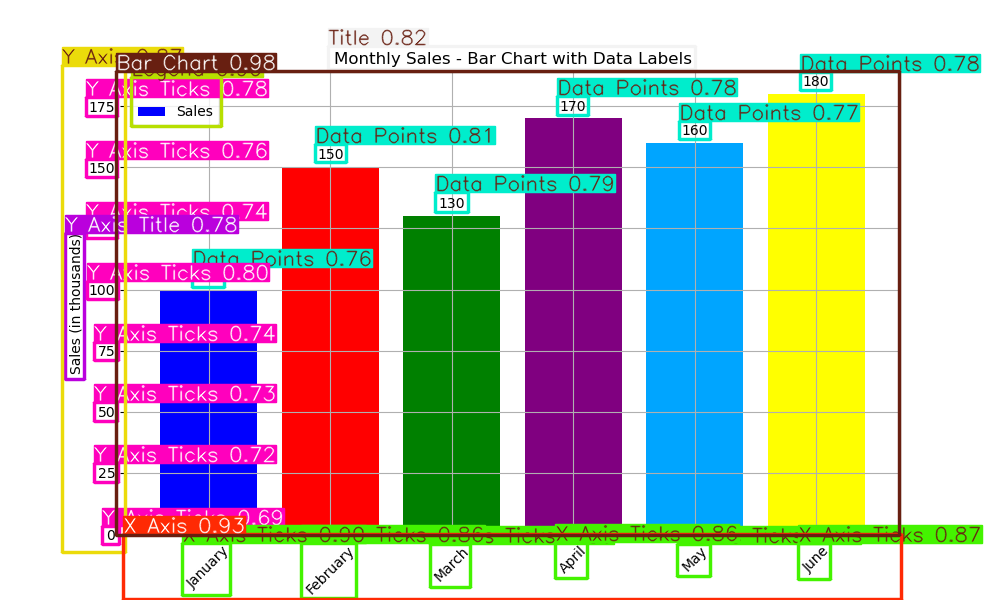

[2025/03/27 14:54:36] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\neel9/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\neel9/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=

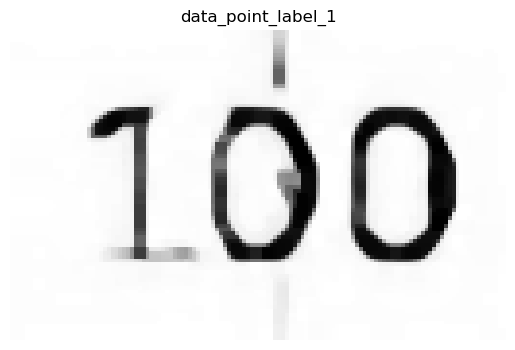

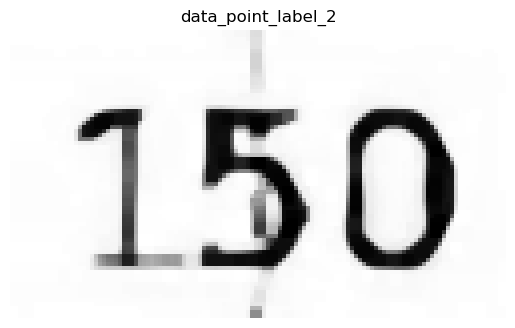

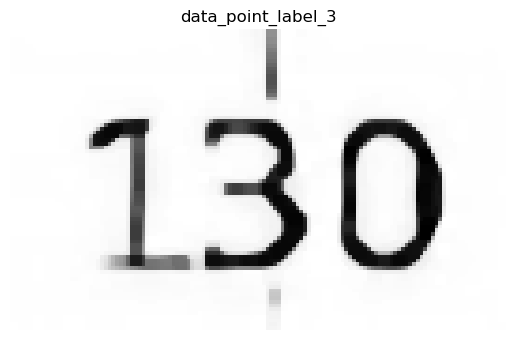

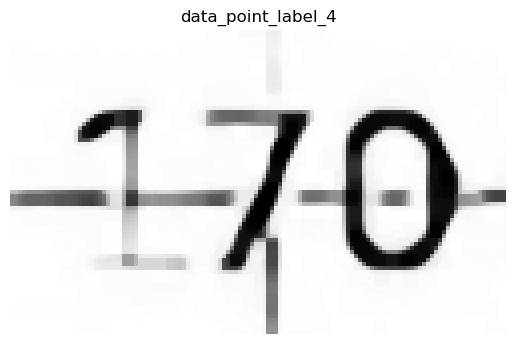

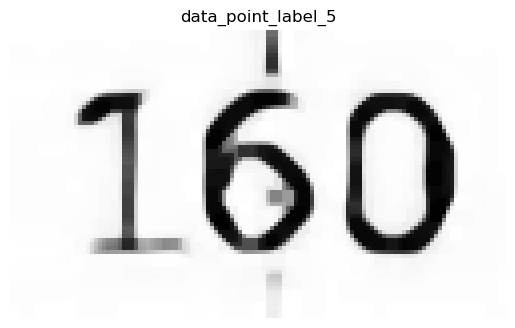

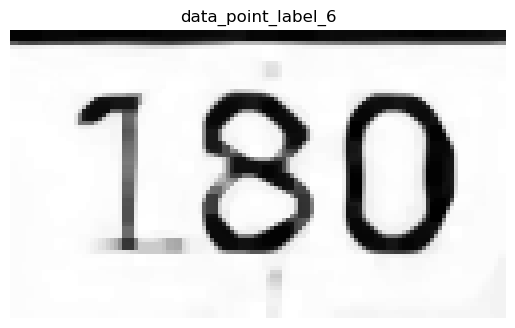

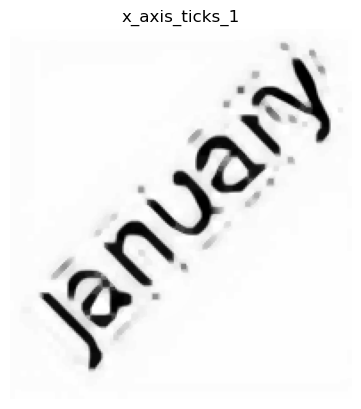

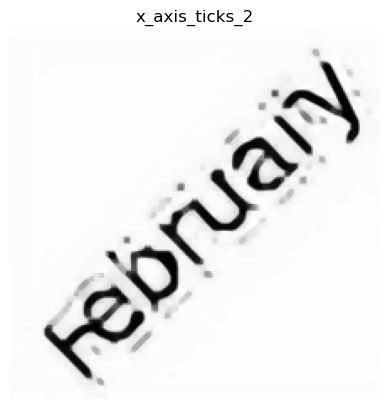

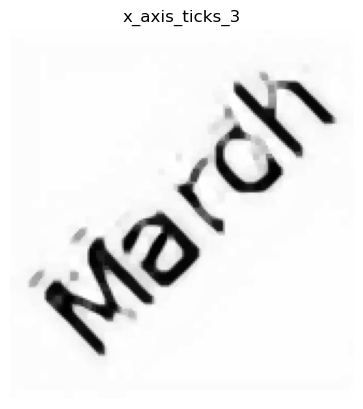

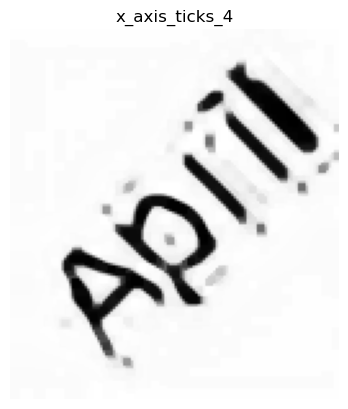

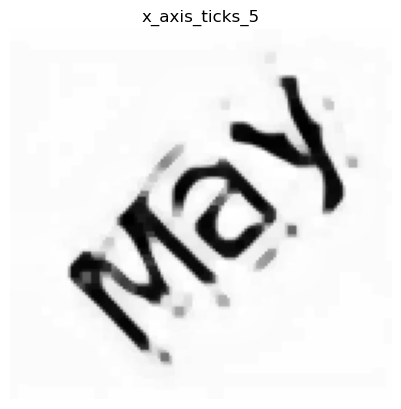

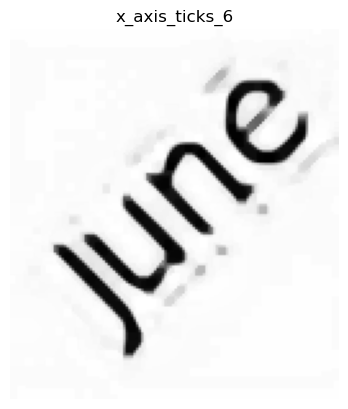

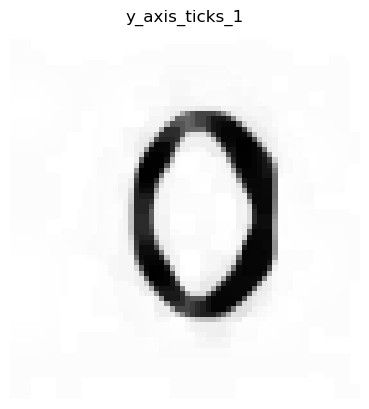

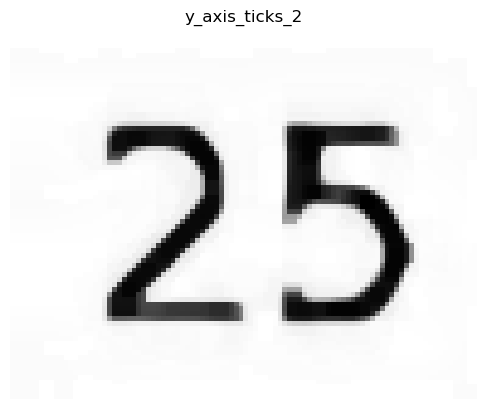

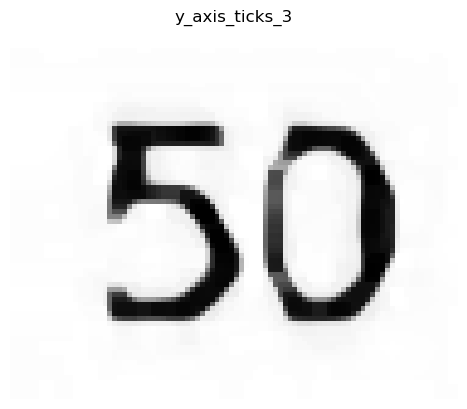

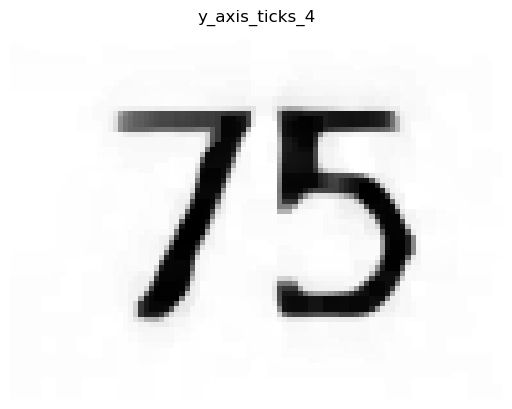

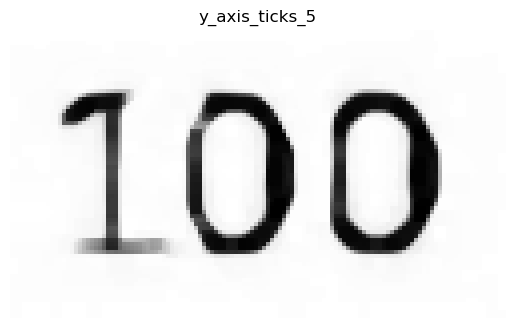

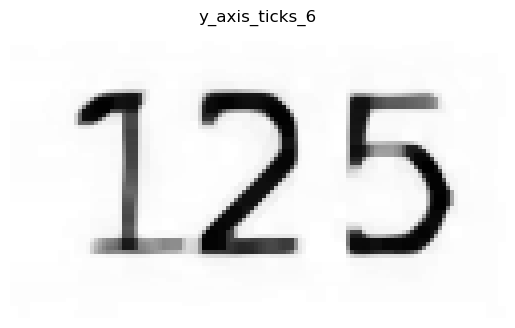

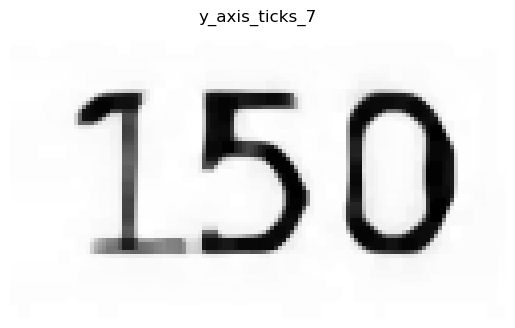

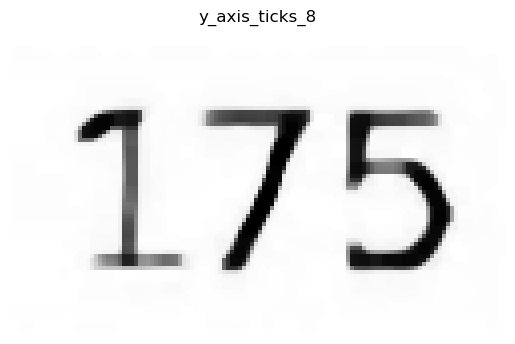

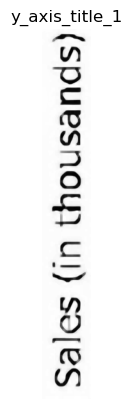

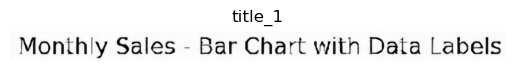

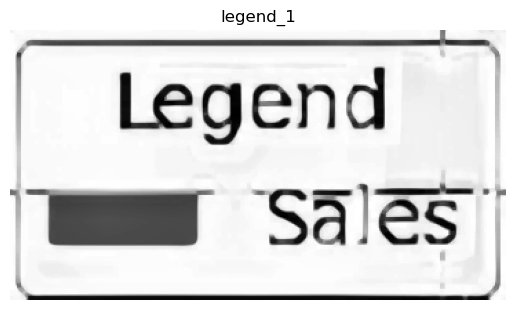

{100.0: 'January',
 150.0: 'Februaiy',
 130.0: 'Mardh',
 170.0: 'April',
 160.0: 'May',
 180.0: 'June'}

In [33]:
process_bar_chart_with_data_points_full(bar_chart_with_data_points)

#### Bar Chart without Data Point Labels

In [34]:
bar_chart_without_data_points = "Test_Images/bar_chart_test_2.png"


image 1/1 C:\Humber College\DataZymes Capstone Project\7th March 2025 Discussion\Test_Images\bar_chart_test_2.png: 480x800 1 X Axis, 1 Y Axis, 1 Title, 1 Bar Chart, 6 X Axis Tickss, 8 Y Axis Tickss, 1 Y Axis Title, 752.3ms
Speed: 10.5ms preprocess, 752.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)


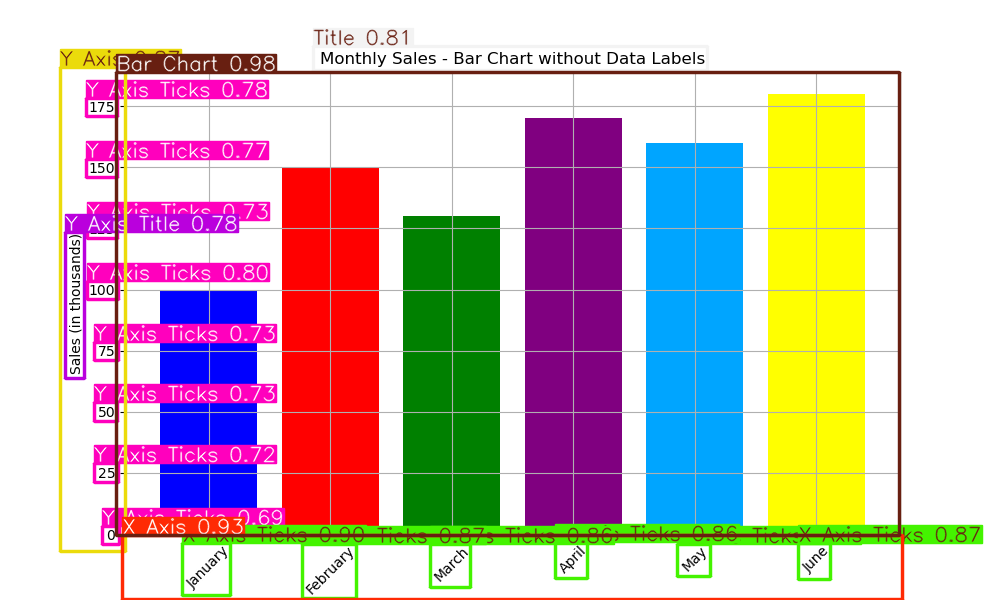

[2025/03/27 14:56:06] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\neel9/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\neel9/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=

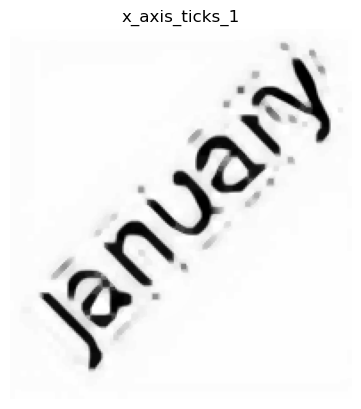

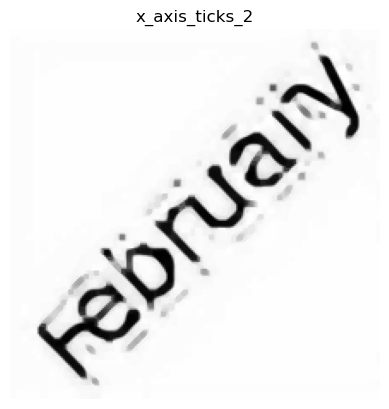

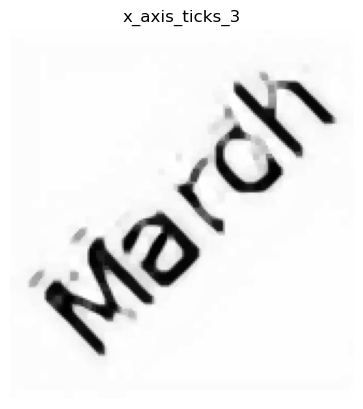

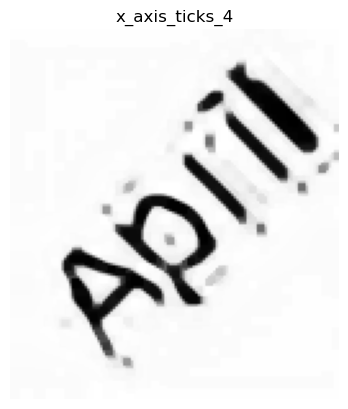

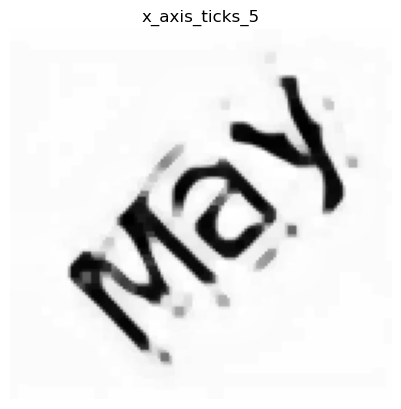

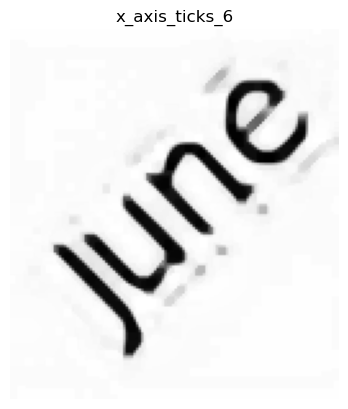

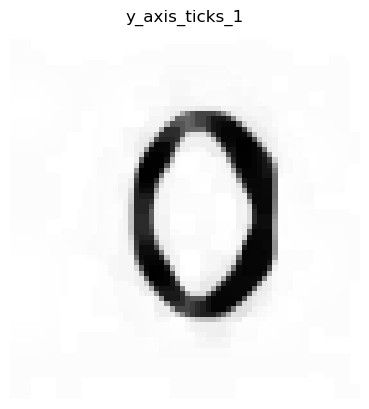

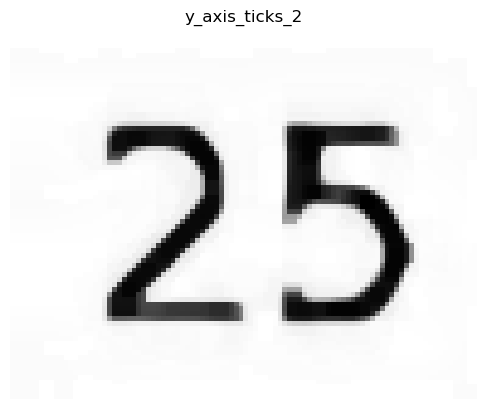

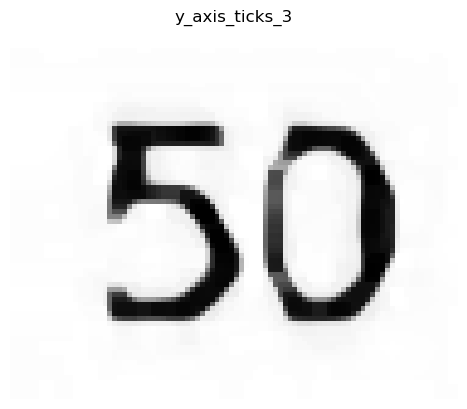

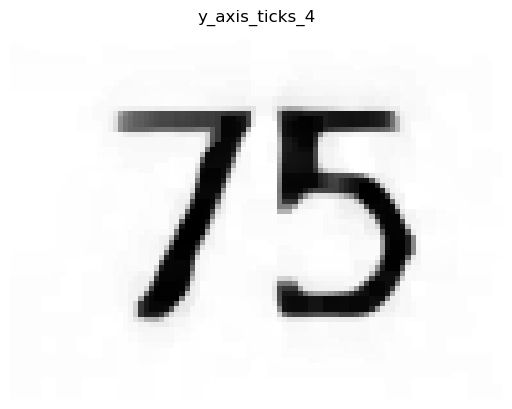

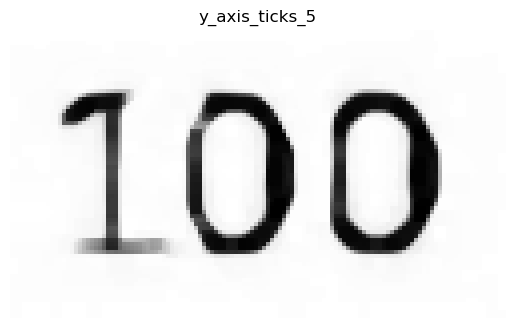

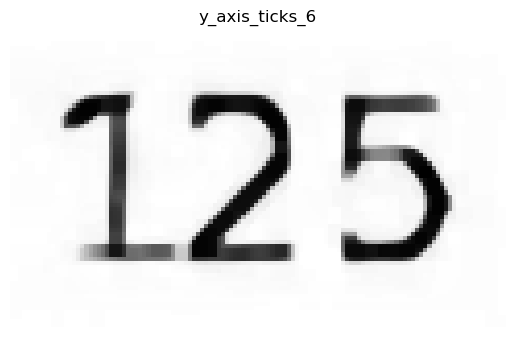

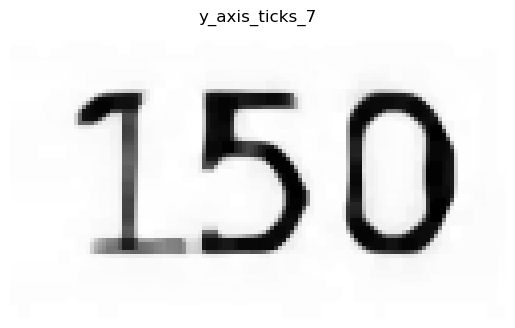

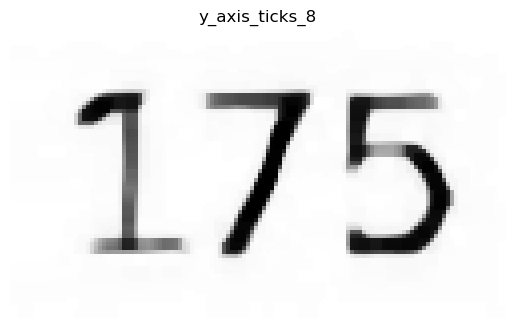

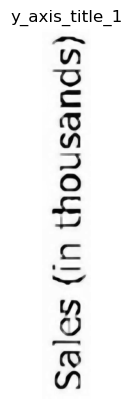

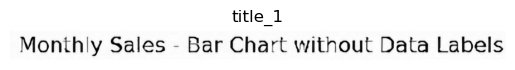

X Axis Tick centers: [206.5073699951172, 329.2112731933594, 814.4474792480469, 450.4939270019531, 571.8174743652344, 693.8343505859375]

Mapping of OCR Tick Values to Expected X Coordinates:
Tick Value January: x = 206.5073699951172
Tick Value Februaiy: x = 329.2112731933594
Tick Value Mardh: x = 450.4939270019531
Tick Value April: x = 571.8174743652344
Tick Value May: x = 693.8343505859375
Tick Value June: x = 814.4474792480469


{'January': 101.95564141491376,
 'Februaiy': 152.25637118627725,
 'Mardh': 132.62681810476954,
 'April': 172.7038223128478,
 'May': 162.0711477270311,
 'June': 182.10964983107021}

In [35]:
process_bar_chart_without_data_points_full(bar_chart_without_data_points)

## Line Charts

#### Line Chart with Data Point Labels

In [36]:
line_chart_with_data_points = "Test_Images/line_chart_test_1.png"


image 1/1 C:\Humber College\DataZymes Capstone Project\7th March 2025 Discussion\Test_Images\line_chart_test_1.png: 448x800 1 X Axis, 1 Y Axis, 1 Title, 1 Line Chart, 10 Data Pointss, 5 X Axis Tickss, 7 Y Axis Tickss, 1 X Axis Title, 1 Y Axis Title, 726.2ms
Speed: 10.4ms preprocess, 726.2ms inference, 13.8ms postprocess per image at shape (1, 3, 448, 800)


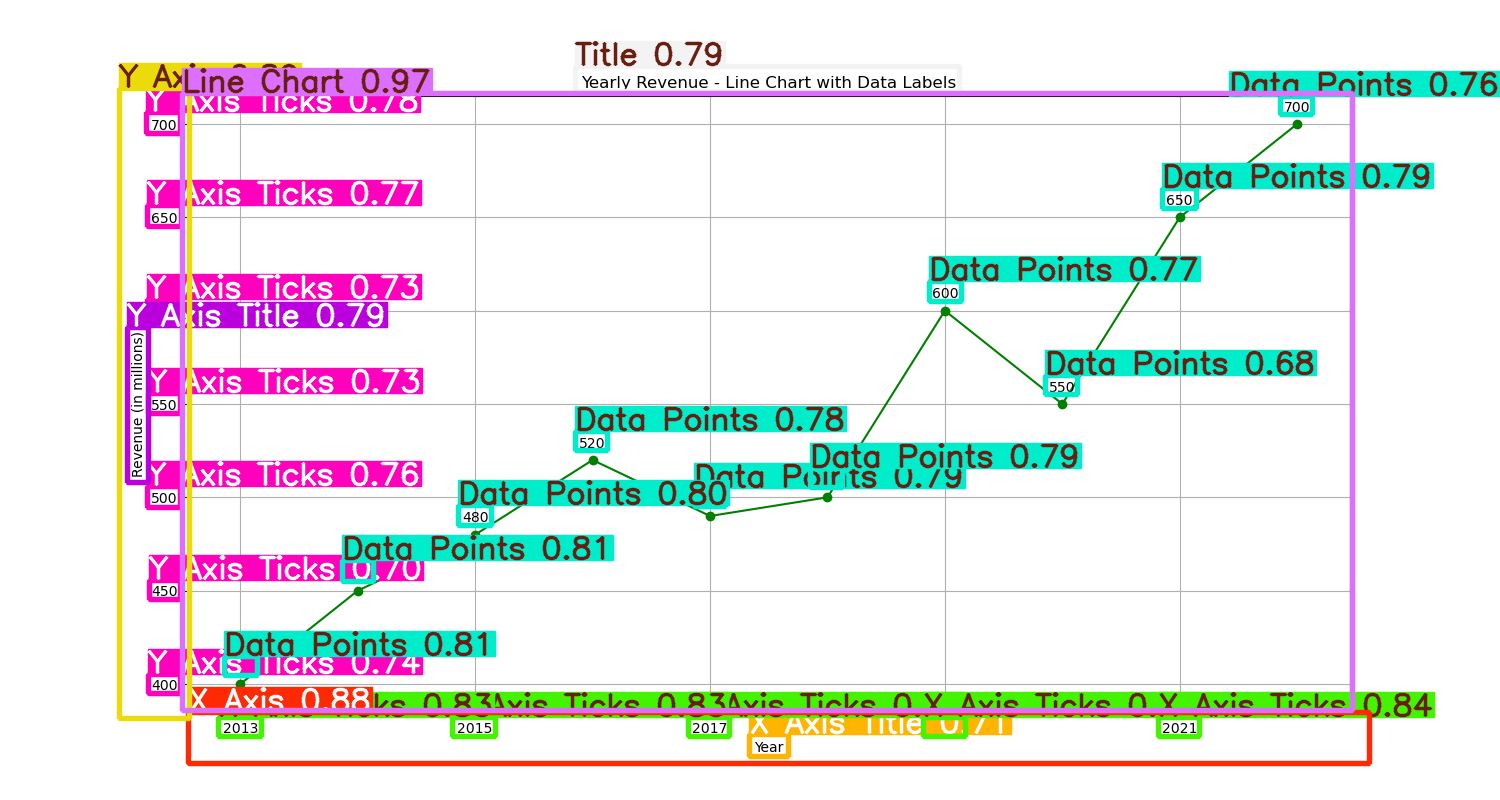

[2025/03/27 14:58:10] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\neel9/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\neel9/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=

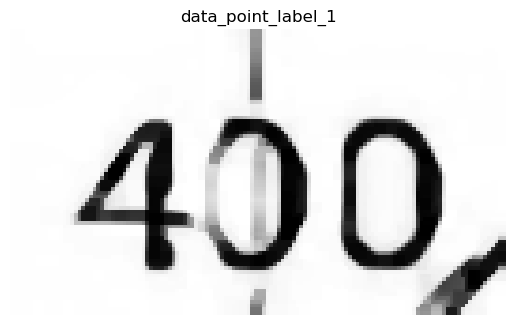

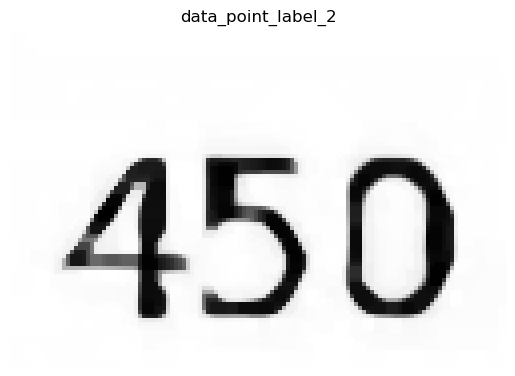

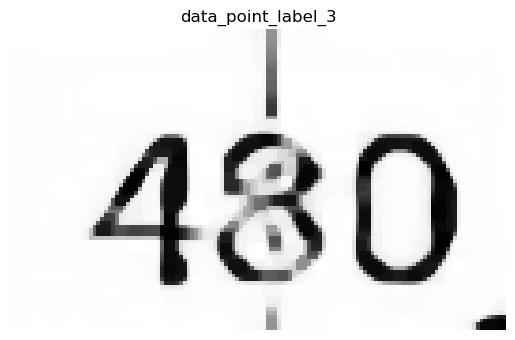

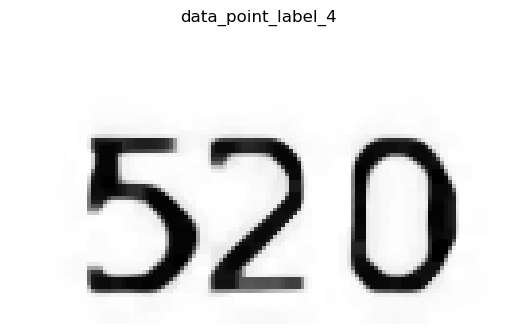

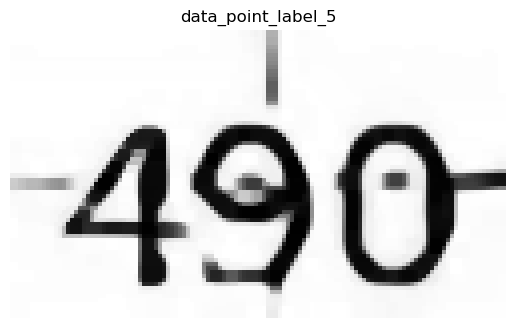

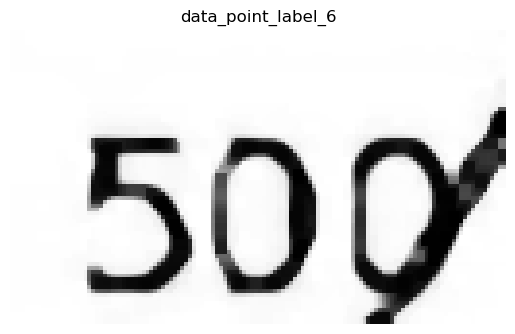

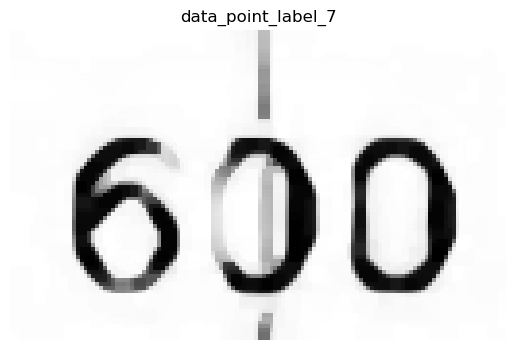

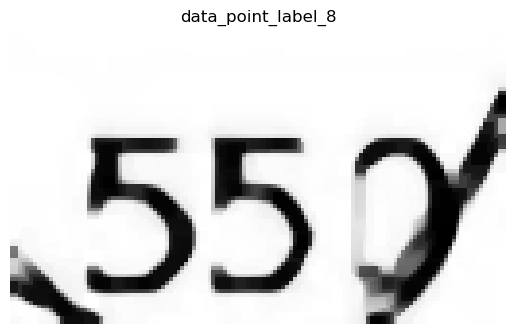

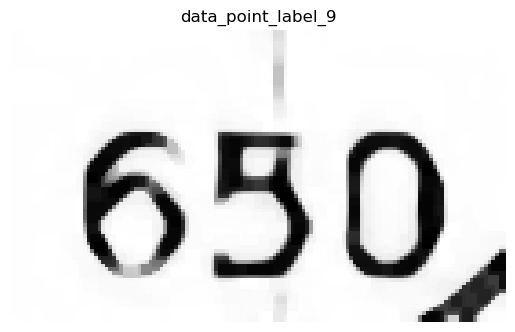

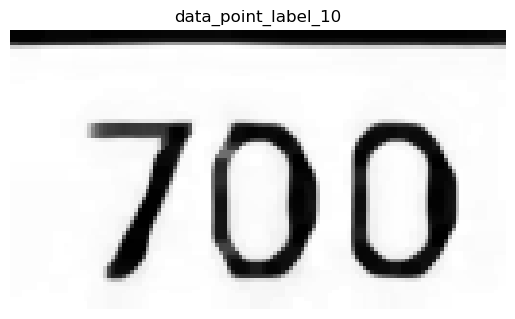

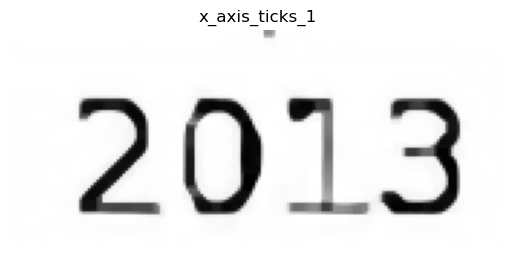

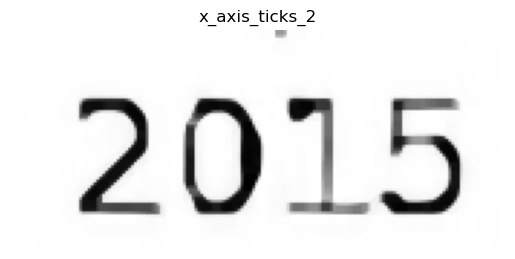

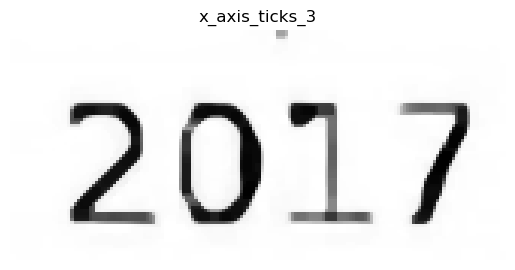

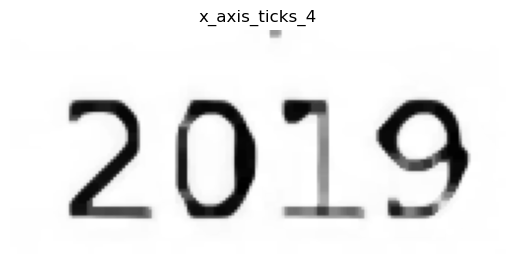

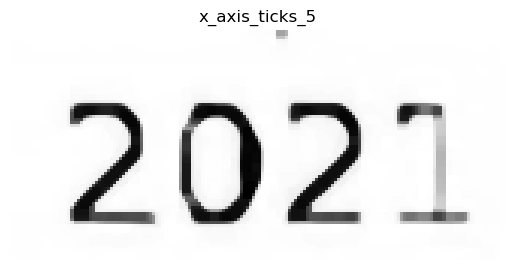

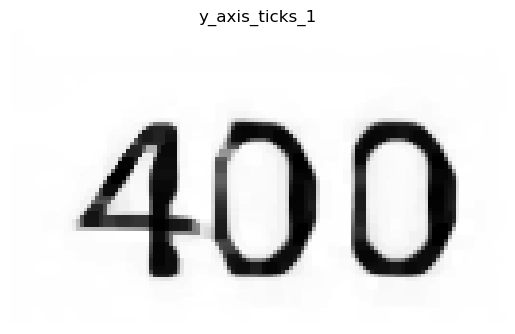

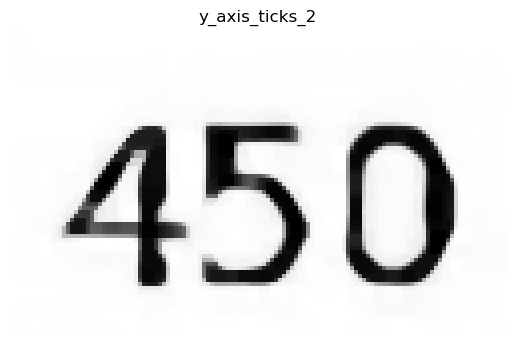

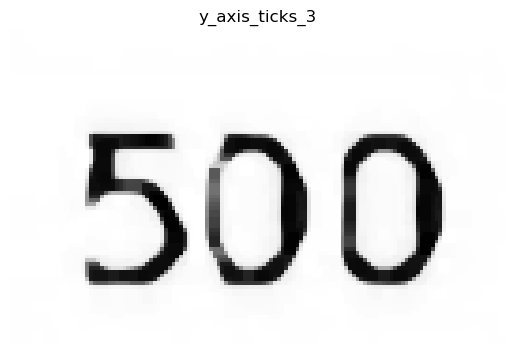

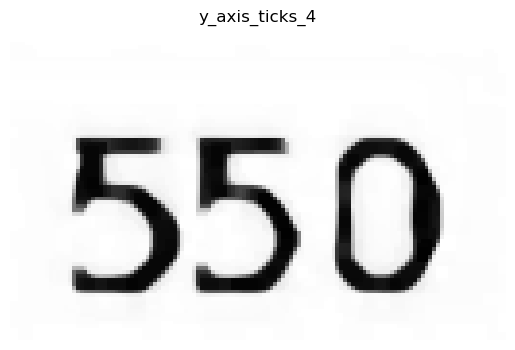

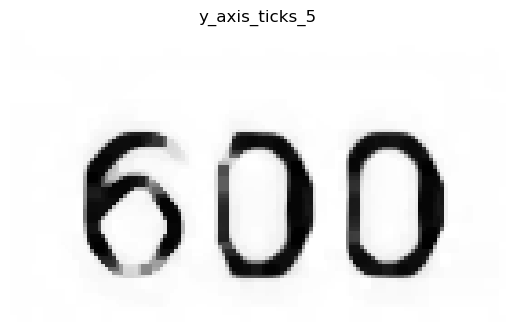

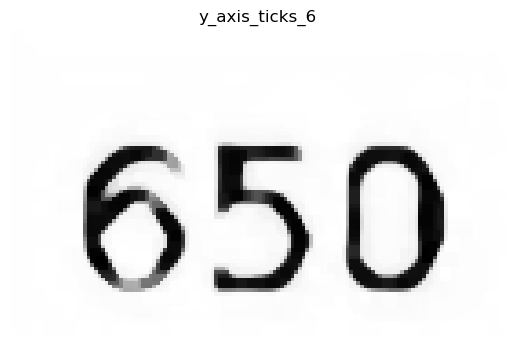

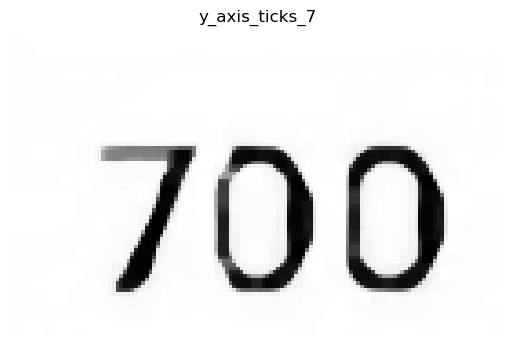

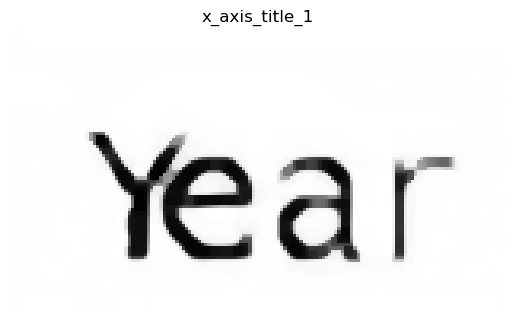

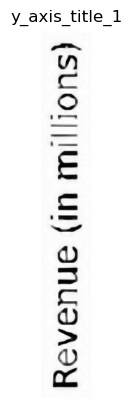

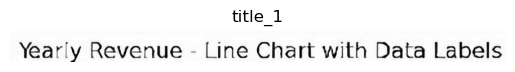

({400.0: '2013',
  450.0: '',
  480.0: '2015',
  520.0: '',
  490.0: '2017',
  500.0: '',
  600.0: '2019',
  550.0: '',
  650.0: '2021',
  700.0: ''},
 'fill in the missing X Axis ticks:\nMapping Value\tX Axis Tick\n1\t2013\n2\t\n3\t2015\n4\t\n5\t2017\n6\t\n7\t2019\n8\t\n9\t2021\n10\t')

In [37]:
process_line_chart_with_data_points_full(line_chart_with_data_points)

#### Line Chart without Data Point Labels

In [38]:
line_chart_without_data_points = "Test_Images/line_chart_test_2.png"


image 1/1 C:\Humber College\DataZymes Capstone Project\7th March 2025 Discussion\Test_Images\line_chart_test_2.png: 448x800 1 X Axis, 1 Y Axis, 1 Title, 1 Line Chart, 10 X Axis Tickss, 7 Y Axis Tickss, 1 X Axis Title, 1 Y Axis Title, 699.8ms
Speed: 10.5ms preprocess, 699.8ms inference, 7.9ms postprocess per image at shape (1, 3, 448, 800)


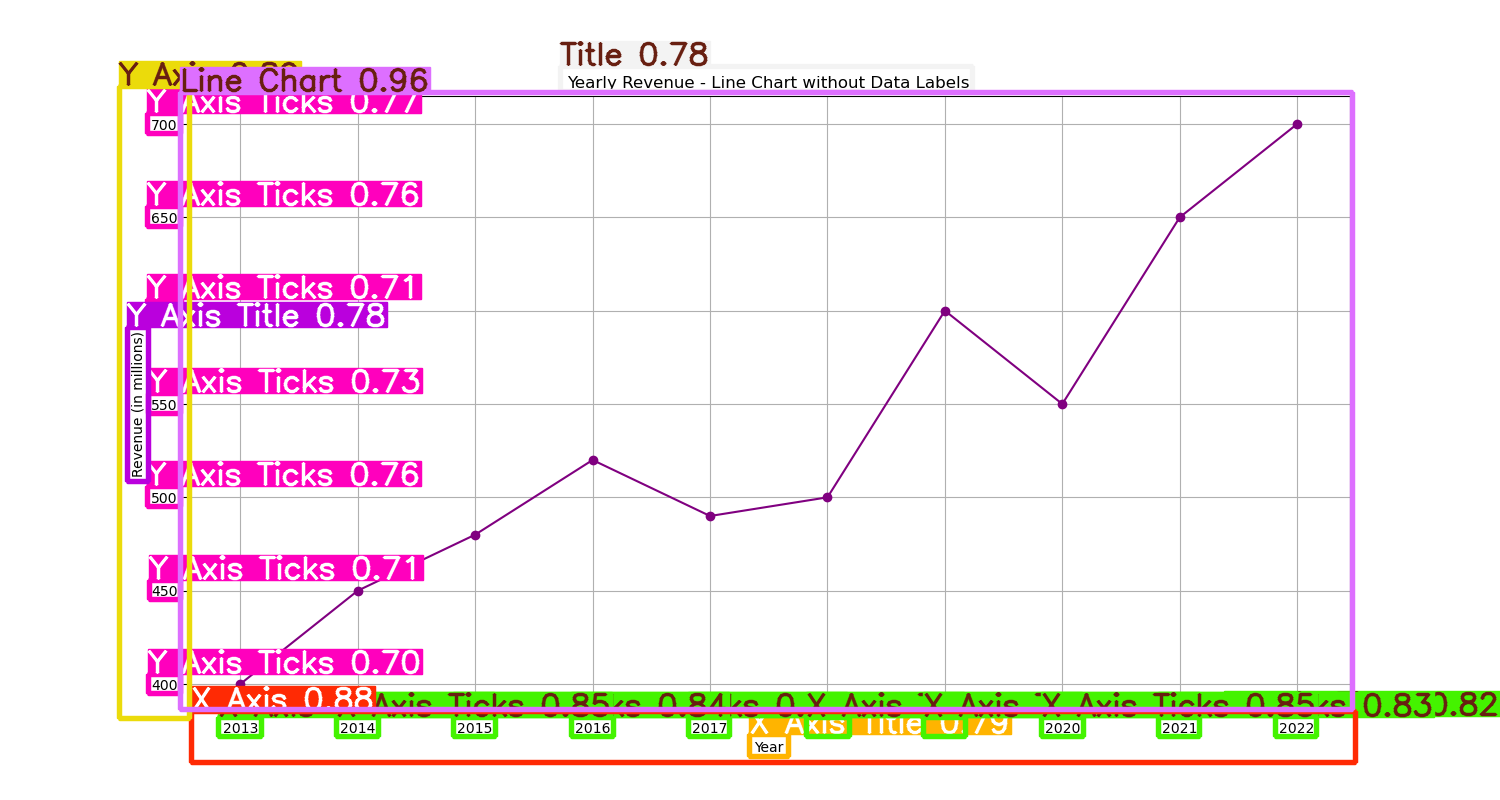

[2025/03/27 15:00:05] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\neel9/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\neel9/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=

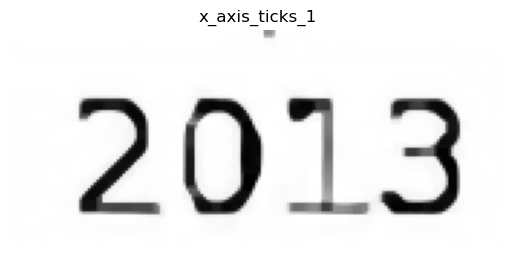

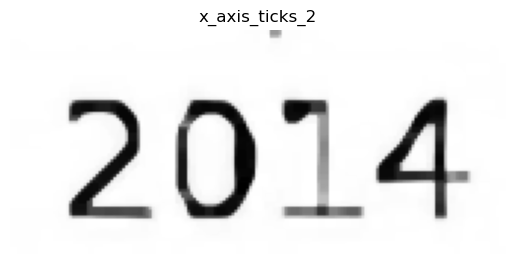

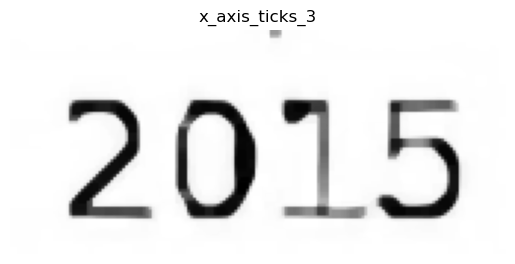

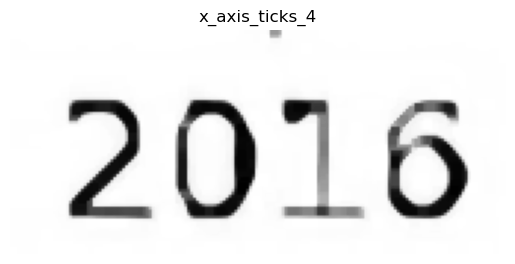

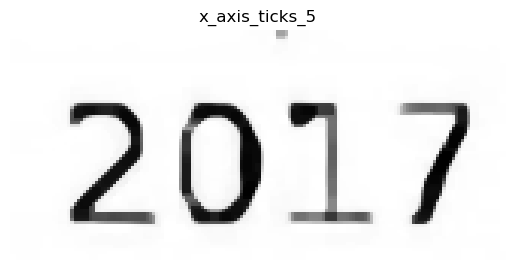

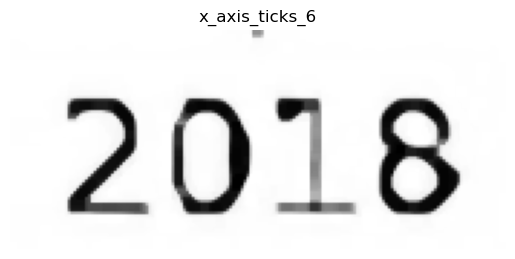

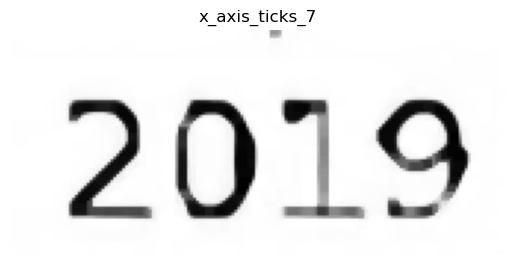

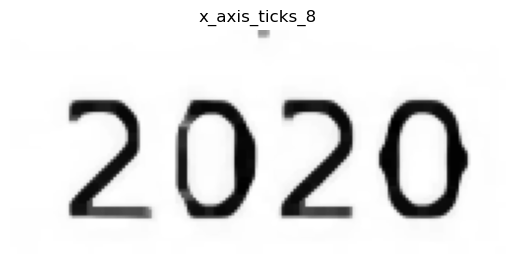

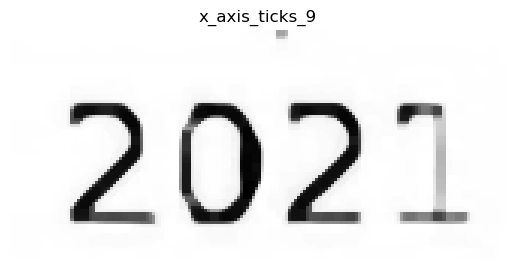

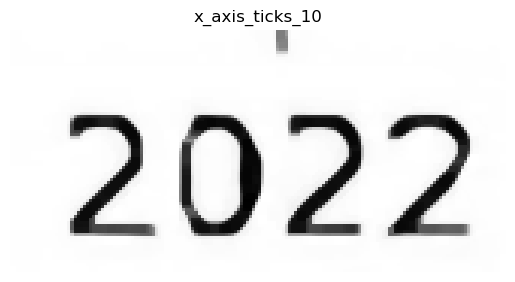

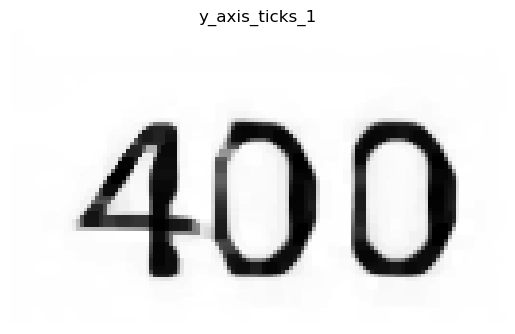

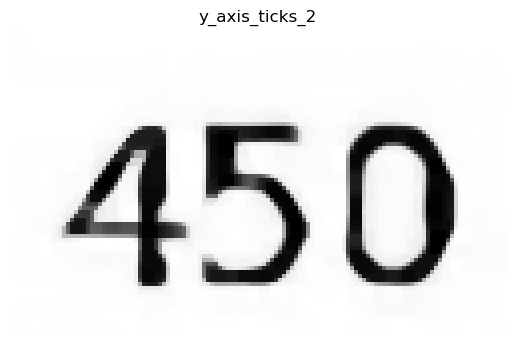

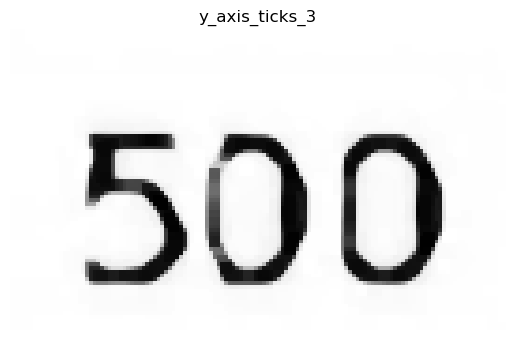

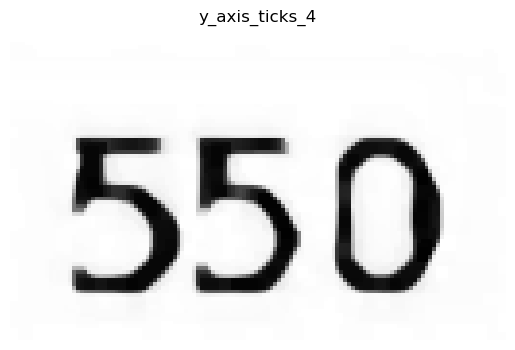

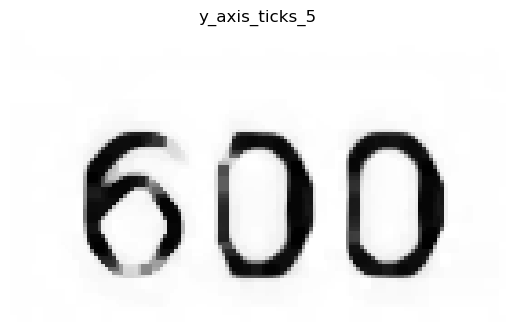

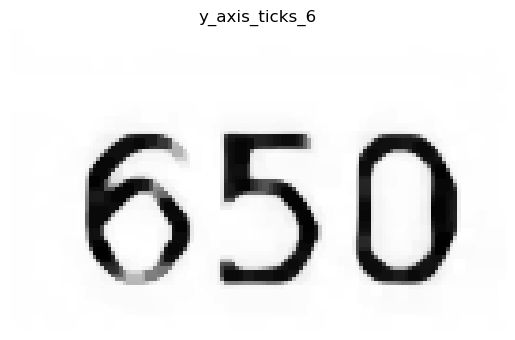

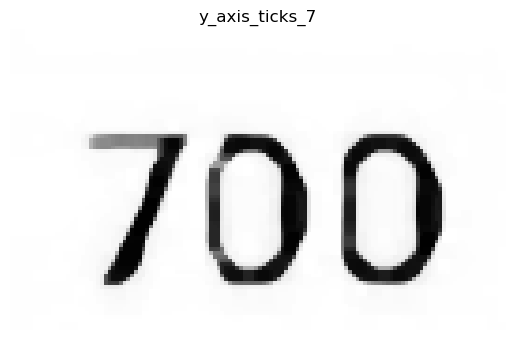

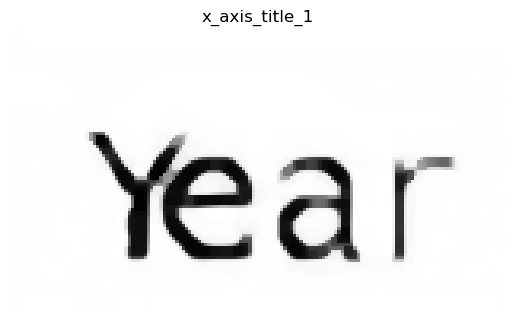

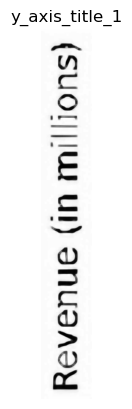

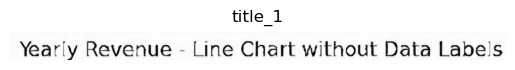

X Axis Tick centers: [357.33917236328125, 1062.666748046875, 239.93002319335938, 944.5804138183594, 827.9389343261719, 474.35736083984375, 1178.9094848632812, 592.4347229003906, 1296.0437622070312, 709.1115417480469]

Mapping of OCR Tick Values to Expected X Coordinates:
Tick Value 2013: x = 239.93002319335938
Tick Value 2014: x = 357.33917236328125
Tick Value 2015: x = 474.35736083984375
Tick Value 2016: x = 592.4347229003906
Tick Value 2017: x = 709.1115417480469
Tick Value 2018: x = 827.9389343261719
Tick Value 2019: x = 944.5804138183594
Tick Value 2020: x = 1062.666748046875
Tick Value 2021: x = 1178.9094848632812
Tick Value 2022: x = 1296.0437622070312
2013: 403.2566195671547
2014: 452.9917675193096
2015: 482.9398135980265
2016: 523.0488038820224
2017: 493.10075780330544
2018: 503.79648854570434
2019: 602.7319979128941
2020: 553.5316364978592
2021: 653.0019324021689
2022: 702.7370803543238


{'2013': 403.2566195671547,
 '2014': 452.9917675193096,
 '2015': 482.9398135980265,
 '2016': 523.0488038820224,
 '2017': 493.10075780330544,
 '2018': 503.79648854570434,
 '2019': 602.7319979128941,
 '2020': 553.5316364978592,
 '2021': 653.0019324021689,
 '2022': 702.7370803543238}

In [39]:
process_line_chart_without_data_points_full(line_chart_without_data_points)

### Pie Chart with Data Point Labels


image 1/1 C:\Humber College\DataZymes Capstone Project\7th March 2025 Discussion\Test_Images\pie_chart_test_1.png: 640x800 1 Title, 1 Legend, 1 Pie Chart, 10 Data Pointss, 1099.1ms
Speed: 26.0ms preprocess, 1099.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 800)


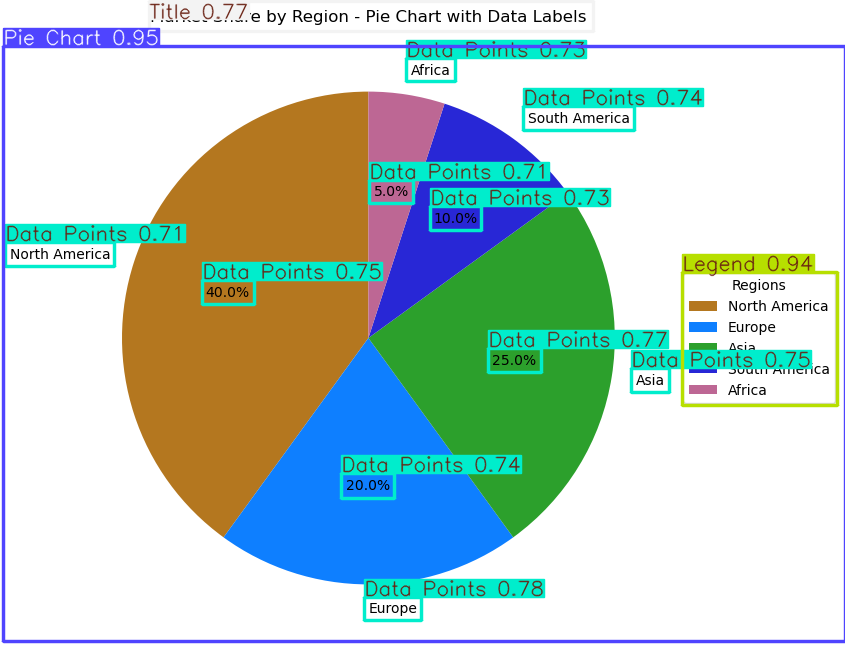

Saved YOLO result image: Test_Images/pie_chart_test_1_pred.png
[2025/03/27 15:23:45] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\neel9/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.3, det_db_unclip_ratio=2.0, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='CRNN', rec_model_dir='C:\\Users\\neel9/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_i

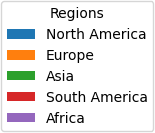

Number of contours found: 5
Found contour at x=8, y=114, width=26, height=7
Candidate block at (8, 114, 26, 7) has average color: (189.00000000000003, 103.00000000000001, 148.0)
Found contour at x=7, y=92, width=28, height=9
Candidate block at (7, 92, 28, 9) has average color: (40.0, 39.0, 214.0)
Found contour at x=7, y=71, width=28, height=9
Candidate block at (7, 71, 28, 9) has average color: (44.0, 160.0, 44.0)
Found contour at x=7, y=50, width=28, height=10
Candidate block at (7, 50, 28, 10) has average color: (14.0, 127.0, 255.0)
Found contour at x=7, y=29, width=28, height=10
Candidate block at (7, 29, 28, 10) has average color: (180.0, 119.0, 31.0)


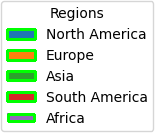

Extracted legend info:
{'legend_entry_1': {'avg_color': (189.00000000000003, 103.00000000000001, 148.0), 'coords': (39, 110, 116, 14)}, 'legend_entry_2': {'avg_color': (40.0, 39.0, 214.0), 'coords': (40, 89, 115, 18)}, 'legend_entry_3': {'avg_color': (44.0, 160.0, 44.0), 'coords': (40, 68, 115, 18)}, 'legend_entry_4': {'avg_color': (14.0, 127.0, 255.0), 'coords': (40, 48, 115, 20)}, 'legend_entry_5': {'avg_color': (180.0, 119.0, 31.0), 'coords': (40, 28, 115, 20)}}
[2025/03/27 15:25:40] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\neel9/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.3, det_db_unclip_ratio=2.0, max_batch_size=10, use_dilation=False, det_

In [43]:
image_path = "Test_Images/pie_chart_test_1.png"
final_mapping = process_full_chart(image_path)

In [44]:
print("Returned Final Mapping:")
print(final_mapping)

Returned Final Mapping:
{'Africa': 5.32, 'South America': 10.02, 'Asia': 25.28, 'Europe': 19.92, 'North America': 39.45}


### Pie Chart without Data Point Labels


image 1/1 C:\Humber College\DataZymes Capstone Project\7th March 2025 Discussion\Test_Images\pie_chart_test_2.png: 640x800 1 Title, 1 Legend, 1 Pie Chart, 5 Data Pointss, 963.5ms
Speed: 13.8ms preprocess, 963.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 800)


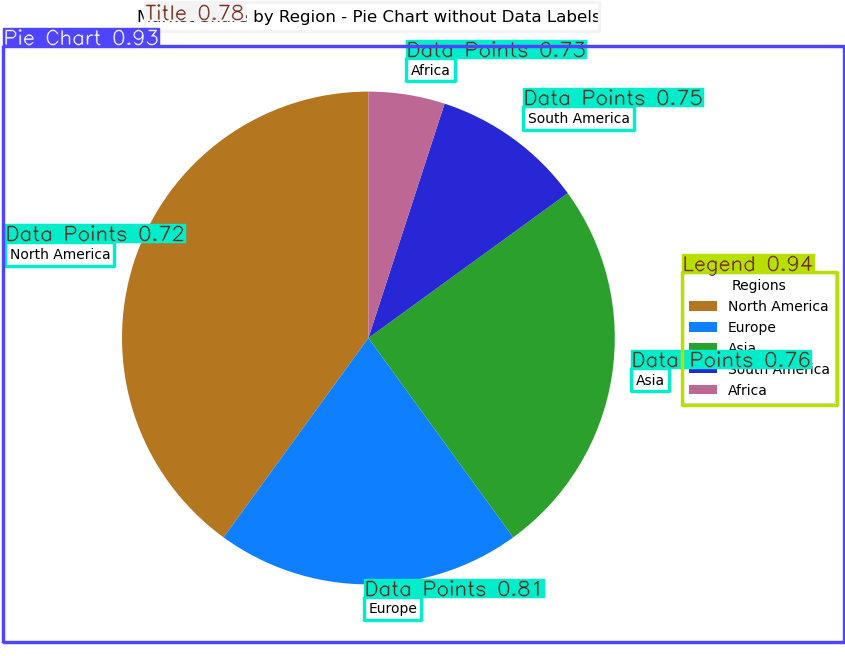

Saved YOLO result image: Test_Images/pie_chart_test_2_pred.png
[2025/03/27 15:26:13] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\neel9/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.3, det_db_unclip_ratio=2.0, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='CRNN', rec_model_dir='C:\\Users\\neel9/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_i

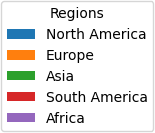

Number of contours found: 5
Found contour at x=8, y=114, width=26, height=7
Candidate block at (8, 114, 26, 7) has average color: (189.00000000000003, 103.00000000000001, 148.0)
Found contour at x=7, y=92, width=28, height=9
Candidate block at (7, 92, 28, 9) has average color: (40.0, 39.0, 214.0)
Found contour at x=7, y=71, width=28, height=9
Candidate block at (7, 71, 28, 9) has average color: (44.0, 160.0, 44.0)
Found contour at x=7, y=50, width=28, height=10
Candidate block at (7, 50, 28, 10) has average color: (14.0, 127.0, 255.0)
Found contour at x=7, y=29, width=28, height=10
Candidate block at (7, 29, 28, 10) has average color: (180.0, 119.0, 31.0)


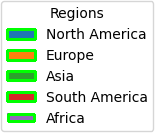

Extracted legend info:
{'legend_entry_1': {'avg_color': (189.00000000000003, 103.00000000000001, 148.0), 'coords': (39, 110, 116, 14)}, 'legend_entry_2': {'avg_color': (40.0, 39.0, 214.0), 'coords': (40, 89, 115, 18)}, 'legend_entry_3': {'avg_color': (44.0, 160.0, 44.0), 'coords': (40, 68, 115, 18)}, 'legend_entry_4': {'avg_color': (14.0, 127.0, 255.0), 'coords': (40, 48, 115, 20)}, 'legend_entry_5': {'avg_color': (180.0, 119.0, 31.0), 'coords': (40, 28, 115, 20)}}
[2025/03/27 15:27:43] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\neel9/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.3, det_db_unclip_ratio=2.0, max_batch_size=10, use_dilation=False, det_

In [45]:
image_path = "Test_Images/pie_chart_test_2.png"
final_mapping = process_full_chart(image_path)

In [46]:
print("Returned Final Mapping:")
print(final_mapping)

Returned Final Mapping:
{'Africa': 5.47, 'South America': 10.41, 'Asia': 24.96, 'Europe': 19.68, 'North America': 39.48}
